# 0.0. IMPORTS

In [117]:
import math
import pandas as pd
import inflection
import numpy as np
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt
import datetime
import warnings

from scipy import stats as ss
from IPython.display import Image
from IPython.core.display import HTML
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( "ignore" )

## 0.1. Helper Functions

In [2]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [4]:
# read_csv é um metodo da classe Pandas
# Preciso "unzipar" o arquivo antes?
# low_memory para dizer se ele lê o arquivo todo (False) ou em pedações (True), ele costuma avisar qual o melhor para a situação
df_sales_raw = pd.read_csv("data/train.csv.zip", low_memory=False)
df_store_raw = pd.read_csv("data/store.csv", low_memory=False)

# Merge (arquivo de referencia, arquivo a ser anexado a essa referencia, como quero fazer o merge, coluna que é igual nos 2 datasets para servir de chave )
# Merge também é um método da classe Pandas
df_raw = pd.merge( df_sales_raw, df_store_raw, how="left", on="Store" )

In [5]:
df_sales_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
df_store_raw.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [7]:
# Plotar uma linha aleatória para ver se deu certo com o método sample
# Granularidade: cada linha tenho vendas por dia por loja
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
800089,305,7,2013-07-14,0,0,0,0,0,1,c,c,2470.0,2.0,2005.0,1,31.0,2013.0,"Mar,Jun,Sept,Dec"


# 1.0. STEP 01 - DATA DESCRIPTION

In [8]:
df1 = df_raw.copy()

## 1.1. Rename Columns

### Para ganhar velocidade no desenvolvimento!

In [9]:
df_raw.columns
# Estão até bem organizadas, formato candle (ou camble?) case, mas no mundo real pode ser bem diferente! rs

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [10]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old) )

# Rename
df1.columns = cols_new

In [11]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

### Saber qual a quantidade de linhas e colunas do dataset

In [12]:
# O shape printa linhas e colunas do dataframe em que primeiro elemento são as rows
# Pq ali são as chaves que ele usa? Isso tem a ver com placeholder?
print( "Number of Rows: {}".format( df1.shape[0] ) )
print( "Number of Cols: {}".format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [13]:
# Atente que não usamos os parênteses aqui. Isso pq estamos vendo uma propriedade e não usando um método?
# O default do pandas é assumir o que não for int como object. Object é o "caracter" dentro do Pandas
# Atente para o date, precisamos mudar de object para datetime!
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [14]:
df1["date"] = pd.to_datetime( df1["date"] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [15]:
# O método isna vai mostrar todas as linhas que tem pelo menos uma coluna com um NA (vazia)
# Mas como eu quero ver a soma disso por coluna, uso o método sum
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [16]:
# Precisamos tratar esses NAs.
# Existem basicamente 3 maneiras:
# 1. Descartar essas linhas (fácil e rápido; mas jogando dado fora)
# 2. Usando algoritmos de machine learning. Tem alguns metodos de input NA que voce pode, por exemplo, substituir as colunas vazias pelo proprio comportamento da coluna (e.g. mediana, media...)
# 3. Entendendo o negócio para colocar valores nos NAs e recuperar dados.

## 1.5. Fillout NA

In [17]:
df1["competition_distance"].max()

75860.0

In [18]:
# competition_distance: distance in meters to the nearest competitor store
# Se pensarmos que não ter o dado nessa coluna significa um competidor estar muito longe geograficamente e, portanto, se assumirmos os valores 
# como muito maiores que a distancia máxima encontrada resolveria o problema?
# Quando uso função lambda, posso usar tudo conforme o nome da variável que defino, no caso x
# Função apply vai aplicar essa logica a todas as linhas do dataset
# Aplica função apply só na coluna competition_distance
# O resultado eu quero sobrescrever na minha coluna original

df1["competition_distance"] = df1["competition_distance"].apply( lambda x: 200000.0 if math.isnan( x ) else x)

# competition_open_since_month - gives the approximate year and month of the time the nearest competitor was opened   
# PREMISSA: Podemos assumir que se essa coluna for NA eu vou copiar a data de venda (extraindo o mês)
# Pq isso? já pensando na etapa a frente de feature engineering... tem algumas variaveis que derivamos do tempo que são muito importantes pra 
# representar o comportamento, uma delas é: quanto tempo faz desde que o evento aconteceu
# A informação de competição proxima é muito importante pois influencia nas vendas! (entao evitamos ao maximo excluir esses dados)
# Primeiro tenho que ver se é NA, uso a classe math. Se isso for verdade, vou pegar a coluna "date" e extrair o mês dela. Se não for verdade, mantem.
# Vou usar função lambda, então posso colocar como x os df1.
# Vou aplicar (função apply) isso ao longo das colunas (axis=1). Não precisamos fazer isso no "competition_distance" pois lá estavamos avaliando
# apenas 1 coluna. Preciso explicitar para a função apply quando tenho mais de uma coluna
# O resultado disso eu vou sobrescrever a coluna "competition_open_since_month"

df1["competition_open_since_month"] = df1.apply( lambda x: x["date"].month if math.isnan( x["competition_open_since_month"] ) else x["competition_open_since_month"] , axis=1)

# competition_open_since_year - gives the approximate year and month of the time the nearest competitor was opened
# Mesma lógica da coluna acima, só que em anos

df1["competition_open_since_year"] = df1.apply( lambda x: x["date"].year if math.isnan( x["competition_open_since_year"] ) else x["competition_open_since_year"] , axis=1)

# promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
# promo2_since_week - describes the year and calendar week when the store started participating in Promo2            
# Dados NA nessa coluna querem dizer que a loja não participa da promoção
# Mesma lógica do de cima

df1["promo2_since_week"] = df1.apply( lambda x: x["date"].week if math.isnan( x["promo2_since_week"] ) else x["promo2_since_week"] , axis=1)

#promo2_since_year  
df1["promo2_since_year"] = df1.apply( lambda x: x["date"].year if math.isnan( x["promo2_since_year"] ) else x["promo2_since_year"] , axis=1)

# promo_interval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. 
# E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store (meses que a promoção ficou ativa)
# Vamos fazer um split dessa coluna e criar uma lista: se a minha data estiver dentro dessa lista (promoção ativa) eu vou criar uma coluna falando 
# que a promo2 foi ativa

# Cria coluna auxiliar
month_map = {1: "Jan",2: "Feb",3: "Mar",4: "Apr",5: "May",6: "Jun",7: "Jul",8: "Aug",9: "Sep",10: "Oct",11: "Nov",12: "Dec"}

# Se o valor na coluna promo_interval for NA, substituo por 0 (não há promoção ativa). inplace=True pois não quero que ele retorne nenhum valor 
# (faça a modificação direto na coluna)
df1["promo_interval"].fillna(0, inplace=True)

# ??? Pq aqui usamos o map ao inves do apply?
# Aqui criamos essa coluna "month_map" que converte a informação de mês da coluna "date" aplicando o dicionário criado month_map
df1["month_map"] = df1["date"].dt.month.map( month_map )

# Se o mês da coluna month_map estiver na promoção, vamos colocar 1, se não estiver, 0
# Temos alguns zeros na coluna "promo_interval" que são lojas que não aderiram a promo2
# uso do método split (já que a coluna "promo_interval" tem os dados dessa forma:  Mar,Jun,Sept,Dec)

# 0 if df1["promo_interval"] == 0 else 1 if df1["month_map"] in df1["promo_interval"].split( "," ) else 0

# Como vou usar mais de uma coluna preciso especificar a direção
# apply(lambda x: 0 if x["promo_interval"] == 0 else 1 if df1["month_map"] in x["promo_interval"].split( "," ) else 0, axis=1 )

# Não vou aplicar no dataset todo, vou filtrar pra ficar mais fácil:
# Vou criar uma nova coluna is_promo que vai ser 1 ou 0

df1["is_promo"] = df1[["promo_interval","month_map"]].apply(lambda x: 0 if x["promo_interval"] == 0 else 1 if x["month_map"] in x["promo_interval"].split( "," ) else 0, axis=1 )

In [19]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [20]:
# Agora a coluna "competition_distance" não tem mais NA e o valor maximo é 200000
df1["competition_distance"].max()

200000.0

In [21]:
# Pegando linhas aleatorias. T para mostrar a transposta
df1.sample(5).T

,526769,633729,570299,296957,69090
store,160,80,205,882,1076
day_of_week,7,2,3,2,7
date,2014-03-16 00:00:00,2013-12-10 00:00:00,2014-02-05 00:00:00,2014-10-28 00:00:00,2015-05-31 00:00:00
sales,0,6473,7556,5047,0
customers,0,492,959,716,0
open,0,1,1,1,0
promo,0,0,1,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,1,0,0
store_type,d,d,a,a,a


## 1.6. Change Types

In [22]:
# Importante checar se alguma operação feita na etapa anterior alterou algum dado anterior
# Método dtypes
# competition_open_since_month           float64
# competition_open_since_year            float64
# Na verdade essas variaveis acima deveriam ser int (mês e ano)

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [23]:
# Método astype nesse caso vai aplicar o int sob essa coluna e vai salvar de volta
df1["competition_open_since_month"] = df1["competition_open_since_month"].astype(int)
df1["competition_open_since_year"] = df1["competition_open_since_year"].astype(int)
df1["promo2_since_week"] = df1["promo2_since_week"].astype(int)
df1["promo2_since_year"] = df1["promo2_since_year"].astype(int)

In [24]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistics

### Ganhar conhecimento de negócio e detectar alguns erros

In [25]:
# Central Tendency = mean, median
# Dispersion = std, min, max, range, skew, kurtosis

# Precisamos separar nossas variáveis entre numéricas e categóricas.
# A estatística descritiva funciona para os dois tipos de variáveis, mas a forma com que eu construo a estatistica descritiva é diferente.

# Vou separar todas as colunas que são numéricas:
# método select_dtypes e vou passar uma lista de todos os tipos de variaveis que quero selecionar
# datetime64(ns) = dado de tempo (date)

# ??? Qual a diferença do int64 e int32?

num_attributes = df1.select_dtypes( include=["int64","int32","float64"] )
cat_attributes = df1.select_dtypes( exclude=["int64", "float64","int32","datetime64[ns]"] )

In [26]:
num_attributes.sample(2)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
850686,727,4,0,0,0,1,0,2050.0,3,2007,0,22,2013,0
392634,131,4,4954,498,1,1,1,920.0,7,2015,0,29,2014,0


In [27]:
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
584079,0,d,a,"Jan,Apr,Jul,Oct",Jan
690447,0,d,c,"Jan,Apr,Jul,Oct",Oct


## 1.7.1 Numerical Attributes

In [28]:
# Apply para aplicar uma operação em todas as colunas e tranformar num dataframe pra facilitar a visualização
# Transpostas para ter metricas nas colunas e features nas linhas

ct1 = pd.DataFrame( num_attributes.apply ( np.mean) ).T #ct1 é um dataframe com a média de cada uma das colunas
ct2 = pd.DataFrame( num_attributes.apply ( np.median ) ).T

d1 = pd.DataFrame( num_attributes.apply( np.std )).T
d2 = pd.DataFrame( num_attributes.apply( min )).T
d3 = pd.DataFrame( num_attributes.apply( max )).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

# Para concatenar todas essas métricas na ordem que quero ver:
# obs: Classe Pandas
# Tem que transpor e resetar o index (Pq???)
# Se não resetar o index nem colocar transporta, dá erro de "Expected axis has 14 elements, new values have 9 elements" 
# Se resetar o index mas nao colocar transposta, dá erro de "Expected axis has 15 elements, new values have 9 elements"
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()

# Vamos nomear as colunas para não aparecer o index padrão
m.columns = ["attributes","min","max","range","mean","median","std","skew","kurtosis"]
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='sales', ylabel='Density'>

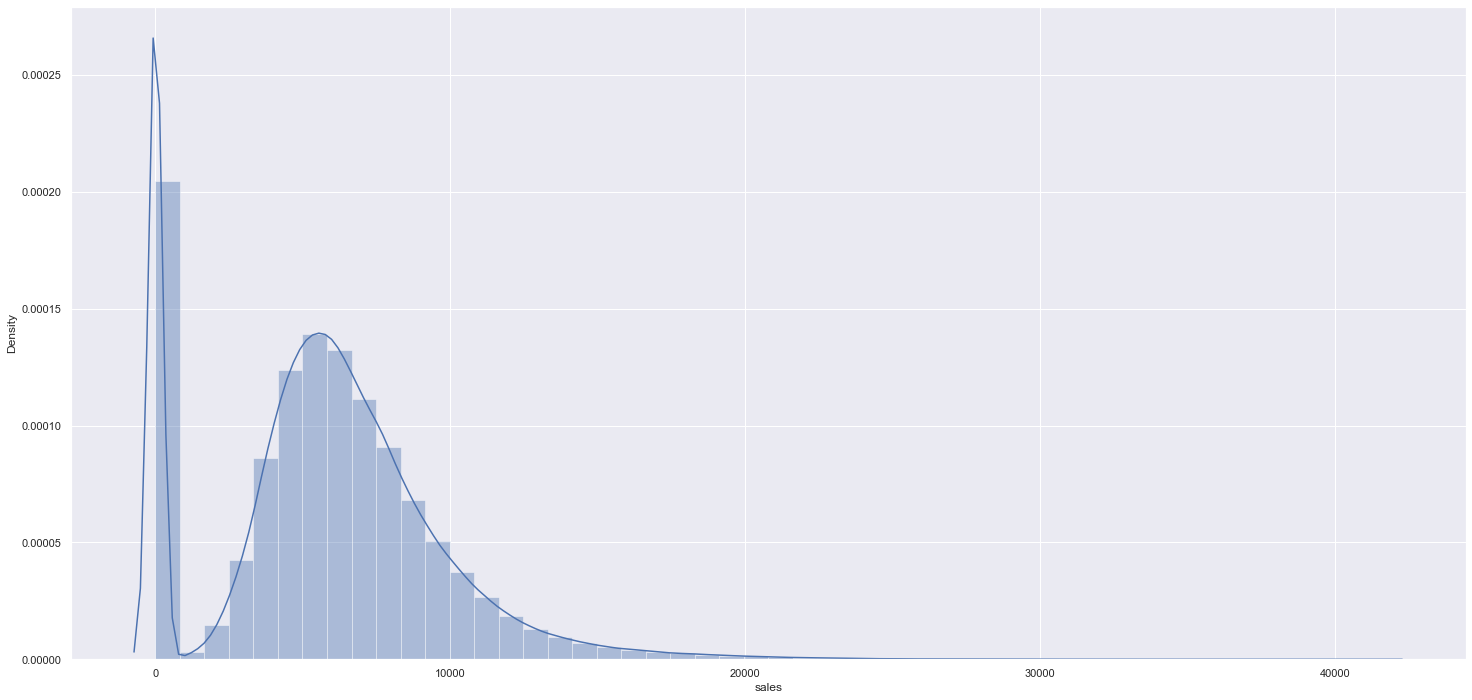

In [130]:
# Plotando as sales passando as colunas que quero mostrar
sns.distplot( df1["sales"] )

<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

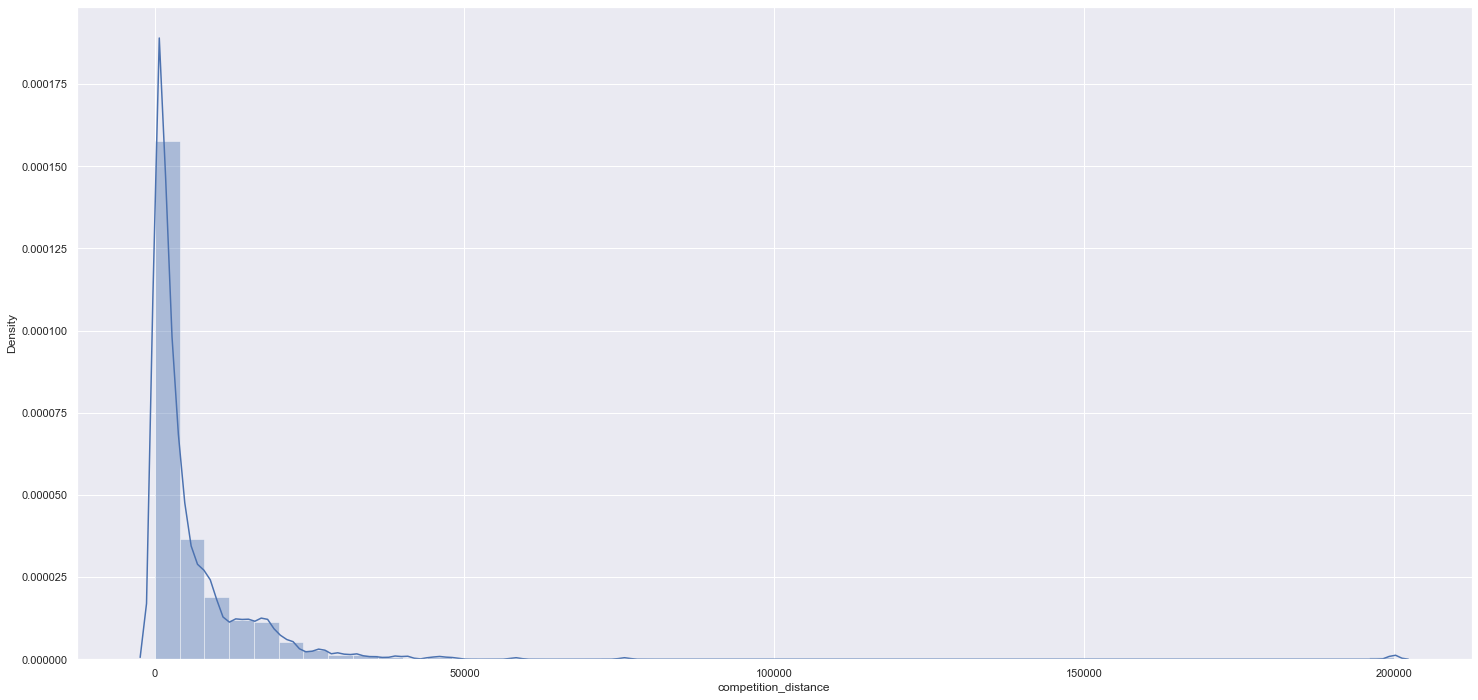

In [131]:
# Skew alta, alta concentração de valores no começo
# Meus competidores estão muito proximos

sns.distplot( df1["competition_distance"])

## 1.7.2 Categorical Attributes

### Vai de boxblot!

In [31]:
# ??? No do Meigarom só apareceu os: state_holiday, store_type, assortment, promo_interval e month_map
# Tirei os int32 tambem dos categoricos
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

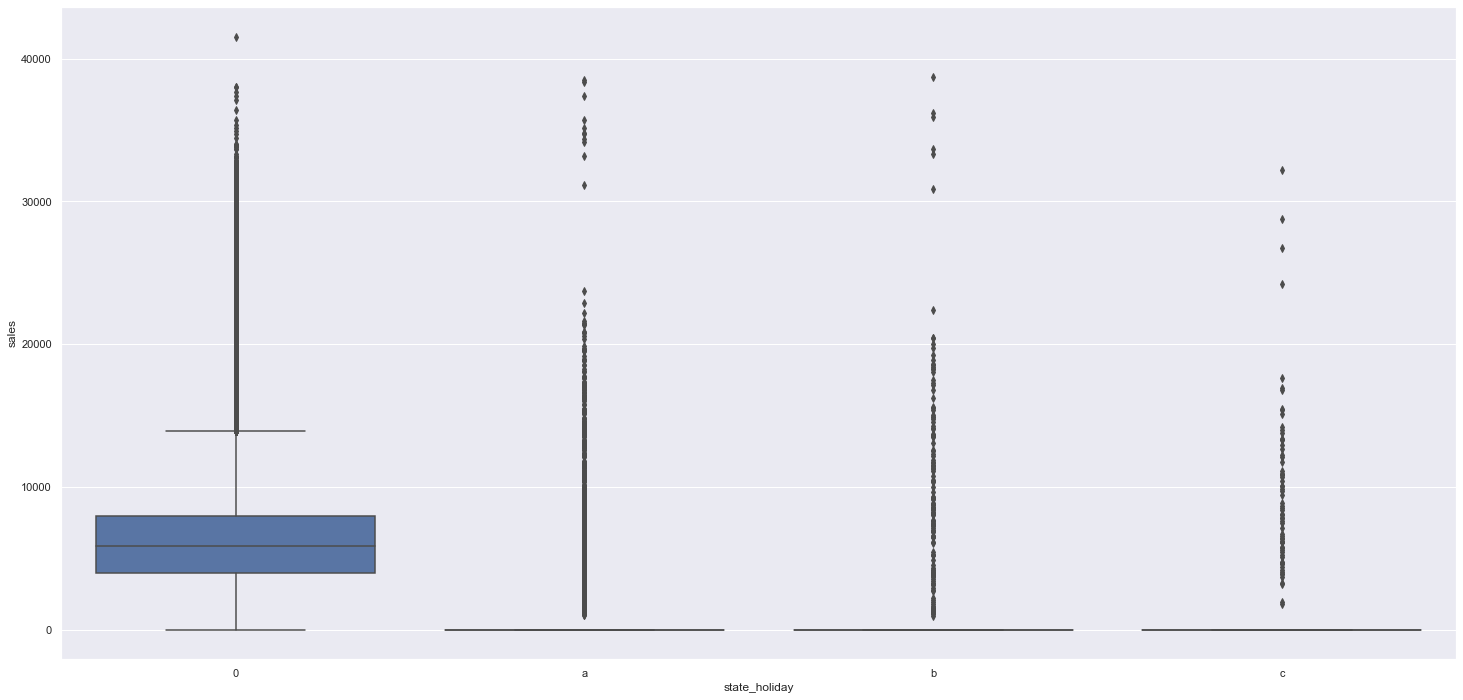

In [32]:
# Meigarom prefere o seaborn do que o matplotlib
# sns.boxplot( x= y=, data= )
# x = linha que vai ficar como referencia
# y = o que quero medir (no caso, as vendas)

# Boxplot:
# Linha do meio é a mediana: chegou na metade dos valores (em termos de posição), aquele valor é sua mediana
# Limite inferior da barra: 25º quartil (quartil 25) e o limite superior é o quartil 75
# Os ultimos tracinhos são em cima o maximo e embaixo o minimo. Todos os pontos acima do tracinho de maximo são considerados outliers (3x o desvio padrão)
# assortment = mix de produtos

sns.boxplot( x="state_holiday", y="sales", data=df1 )

<AxesSubplot:xlabel='assortment', ylabel='sales'>

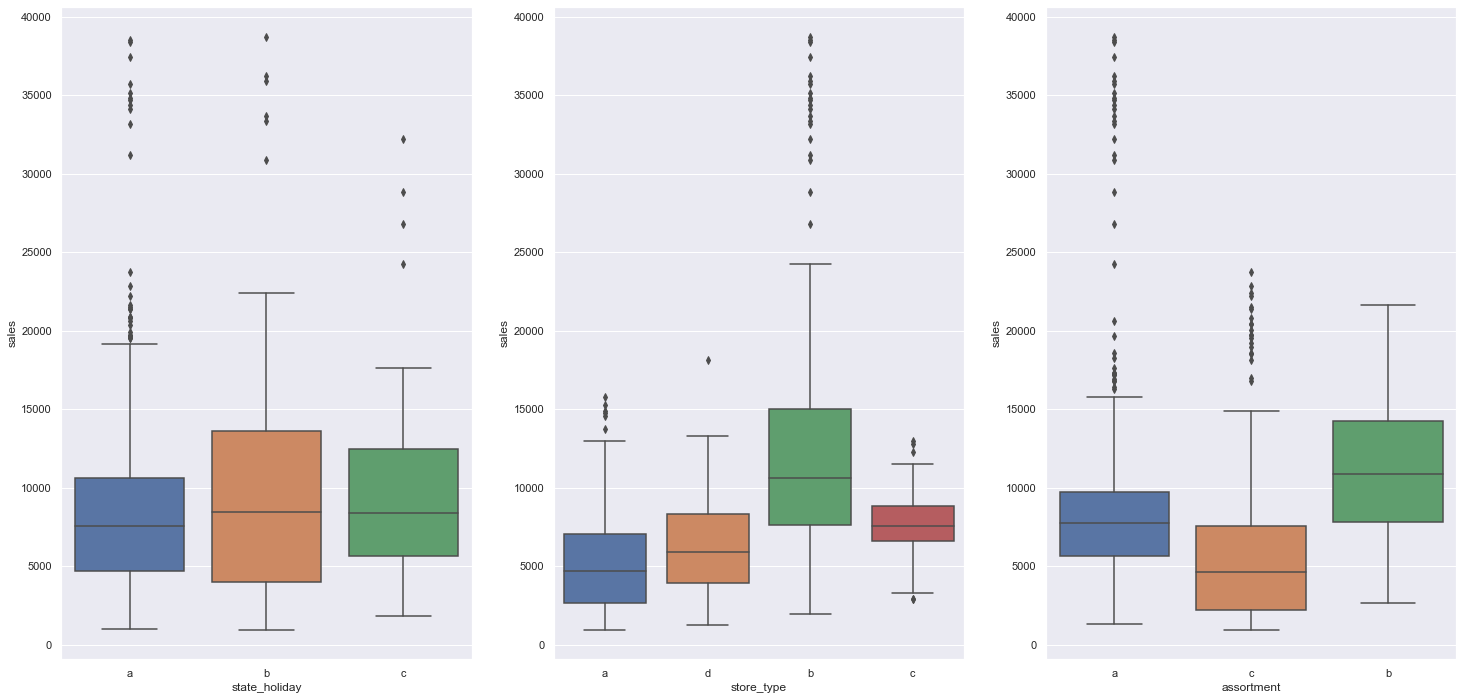

In [33]:
# Se plotamos da forma acima não da pra ver nada... (variaveis com ranges mt diferentes)
# Vamos filtrar os dados para plotar:
# ??? Pq esse 0 é uma string e nao um numero? df1["state_holiday"] != "0"

aux1 = df1[(df1["state_holiday"] != "0") & (df1["sales"] > 0)]

# plt.subplot = para plotar um do lado do outro

plt.subplot( 1, 3, 1 ) # linha, coluna, posição
sns.boxplot( x="state_holiday", y="sales", data=aux1)

plt.subplot( 1, 3, 2 )
sns.boxplot( x="store_type", y="sales", data=aux1)

plt.subplot( 1, 3, 3 )
sns.boxplot( x="assortment", y="sales", data=aux1)

# 2.0. STEP 02 - FEATURE ENGINEERING

Para quê fazer a Feature Engineering? Para ter as variáveis DISPONÍVEIS para ESTUDO durante a Análise Exploratória dos Dados. Pra não ter bagunça, crie as variáveis ANTES na análise exploratória!!!

Vou usar uma classe Image para colocar a imagem do mapa mental:

In [34]:
df2 = df1.copy()

## 2.1. Hypothesis Mind Map 

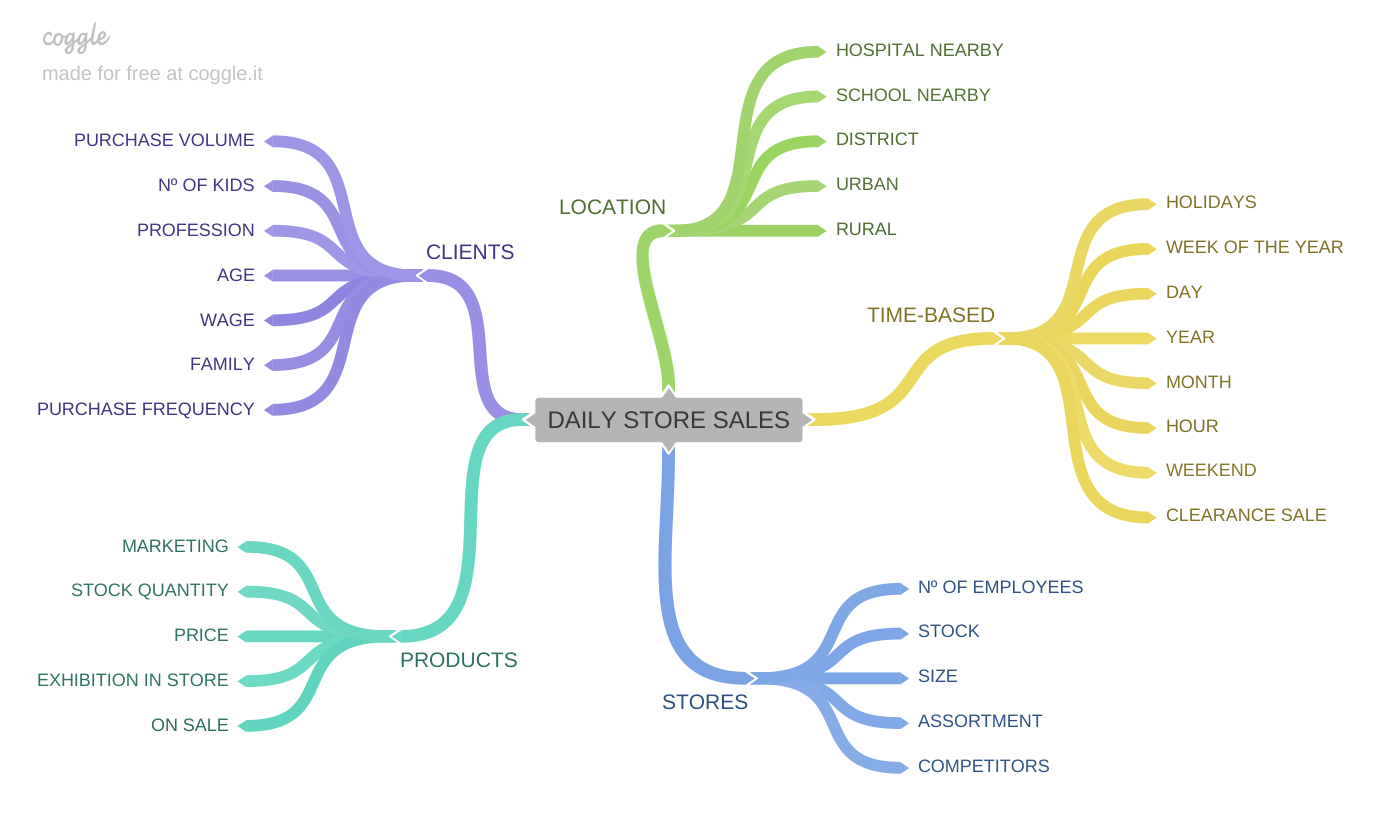

In [35]:
Image ("img/mind-map-hypothesis.png")

## 2.2. Hypothesis Creation

### 2.2.1 Store Hypothesis

1. Stores with greater number of employees should sell more.

2. Stores with greater stock size should sell more.

3. Stores with bigger size should sell more.

4. Stores with smaller size should sell less.

5. Stores with greater assortment should sell more.

6. Stores with more competitors nearby should sell less.

7. Stores with competitors for longer should sell more. 

### 2.2.2 Product Hypothesis

1. Stores with more marketing should sell more.

2. Stores that exhibit more products in the showcase sell more.

3. Stores that have lower prices on products should sell more.

4. Stores that have lower prices for longer on products should sell more.

5. Stores with more consecutive sales should sell more.

### 2.2.3Time-based Hypothesis

1. Stores with more days in holidays should sell less.

2. Stores that open in the first 6 months should sell more.

3. Stores that open on weekends should sell more.

## 2.3. Final Hypothesis List

### As hipóteses das quais temos os dados, vão para a lista final de hipóteses.



1. Stores with greater assortment should sell more.

2. Stores with more competitors nearby should sell less.

3. Stores with competitors for longer should sell more. 

4. Stores with active sales for longer should sell more.

5. Stores with more days on sale should sell more.

7. Stores with more consecutive sales should sell more.

8. Stores opened during the Christmas holiday should sell more.

9. Stores should sell more over the years.

10. Stores should sell more in the second half of the year.

11. Stores should sell more after the 10th of each month.

12. Stores should sell less on weekends.

13. Stores should sell less during school holidays. 

## 2.4. Feature Engineering

In [36]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
# aqui não usaremos nenhum metodo, e sim mudaremos a formatação da data apenas
# ele fala do strftime no bônus
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# week of year 
# ps: <ipython-input-35-d06c5b7375c4>:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
#  df2["week_of_year"] = df2["date"].dt.weekofyear

df2["week_of_year"] = df2["date"].dt.isocalendar().week

# competition since
# ja temos a coluna "date" para comparar, mas a informação de competition since está quebrada, temos coluna com year e outra com month
# Precisamos juntar as duas em uma data e fazer a substração das duas
# método datetime vem de uma classe também chamada datetime
# datetime.datetime( year=, month=, day= )

# datetime.datetime( year= df2["competition_open_since_year"], month= df2["competition_open_since_month"], day= 1 )
# Vamos usar a função acima para todas as linhas do dataframe vamos usar lambda com variavel x e depois usar o apply
# day = 1 pois nao temos informação sobre o dia
# o apply vai precisar do axis pois estou usando duas colunas diferentes

# competition since, essa nova coluna vai pegar informaçao de duas colunas diferentes, 
# usando o datetime para definir e padronizando o dia como 1 ja que nao temos informaçao dos dias
# o axis é usando para o apply
df2["competition_since"] = df2.apply(lambda x: datetime.datetime( year= x["competition_open_since_year"], month= x["competition_open_since_month"], day= 1), axis=1 )
# com esse comando acima geramos a coluna "competition_since" no formato 2008-09-01 00:00:00. Agora precisamos ver a diferença dessa data com a date para saber o tempo 

# df2['date'] - df2['competition_since'] )/30   
# divido por 30 pq quero manter a glanularidade em dias 
# o .days vai extrair os dias desse datetime e salva como inteiro em uma nova coluna 'competition_time_month'
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
# Para as promoçoes temos uma dificuldade a mais pois temos a coluna promo2 e informação de ano e semana
# não temos de mês
# Vamos fazer um join dos caracteres e depois converter na data
# Mas para juntar as variáveis assim precisamos que as 2 sejam strings (astype converte)
# colocamos o "-" pra ficar no formato ano - semana do ano

df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
# "promo_since" agora e string, nao é datetime

# Deu uma complicada nesse promo, mas bora lá...
# Truque para converter para data: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ). strptime( o que vai mostrar, "formato")
# x pq vamos aplicar para todas as linhas do dataframe
# /7 para ter em semanas

df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment (describes an assortment level: a = basic, b = extra, c = extended)
# Mudar as letras para o que isso representa pra ficar mais facil a leitura:
# Pq else e não elif na estrutura dentro do lambda???
# ??? object type é tipo string?
# Nao preciso usar o axis pq só vou usar a coluna "assortment"

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# Mesma coisa do assortment no "state holiday"
# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )


In [37]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. STEP 03 - VARIABLES FILTERING

In [38]:
# Antes de qualquer coisa, ao começar um novo passo, copia o dataset do passo anterior e passa a trabalhar com um novo
df3 = df2.copy()

In [39]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Rows Filtering

In [40]:
# "open" != 0 & "sales" > 0

df3 = df3[(df3["open"] != 0) & (df3["sales"] > 0)]

## 3.2. Columns Selection

In [41]:
# Vamos "dropar" as colunas que não queremos
# A "open" está aqui pois após tirarmos as linhas cujos dados da coluna "open" eram 0, só sobraram valores 1, então é uma coluna 'inútil'
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
# Drop é um metodo da classe Pandas (quais colunas e sentido); axis 0 = linhas, axis 1 = colunas
df3 = df3.drop( cols_drop, axis=1 )


In [42]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. STEP 04 - EXPLORATORY DATA ANALYSIS

In [43]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1 Response Variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

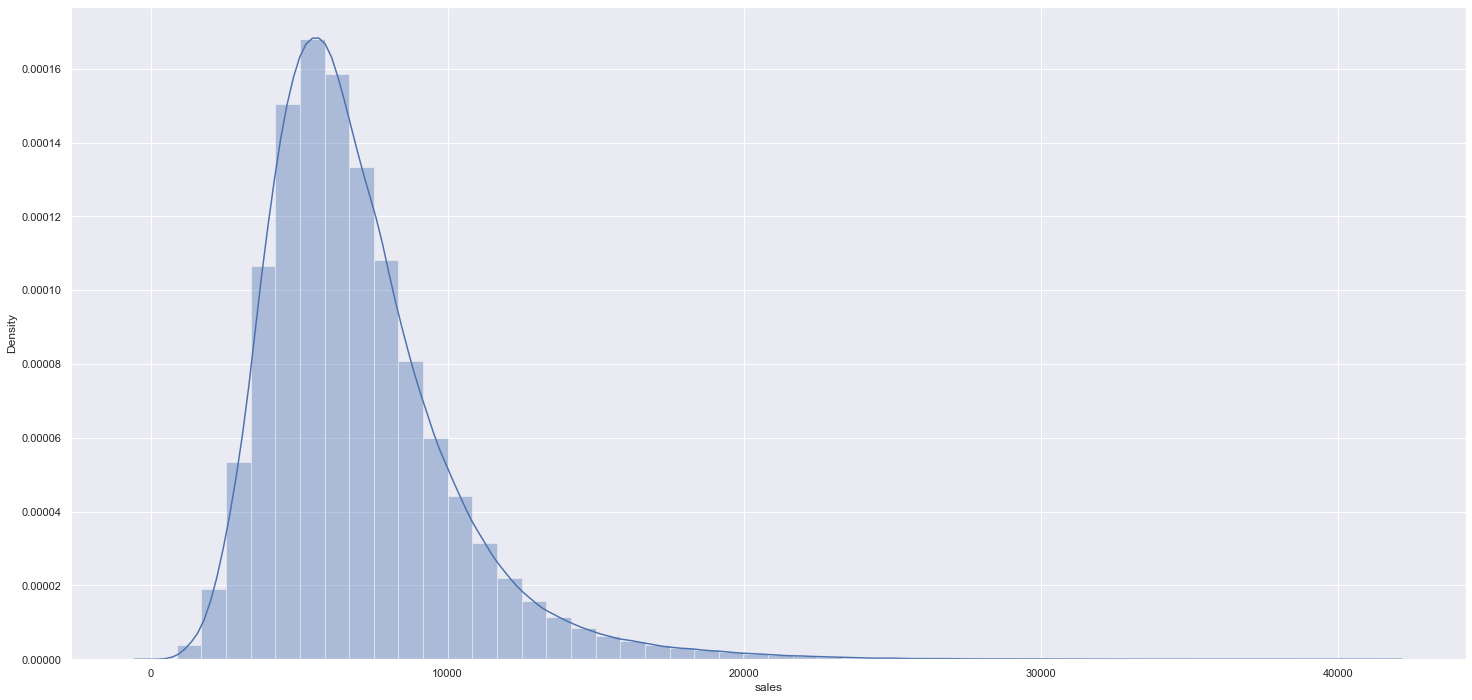

In [132]:
# Plotando a distribuição da variável resposta

sns.distplot(df4["sales"])

<AxesSubplot:xlabel='sales'>

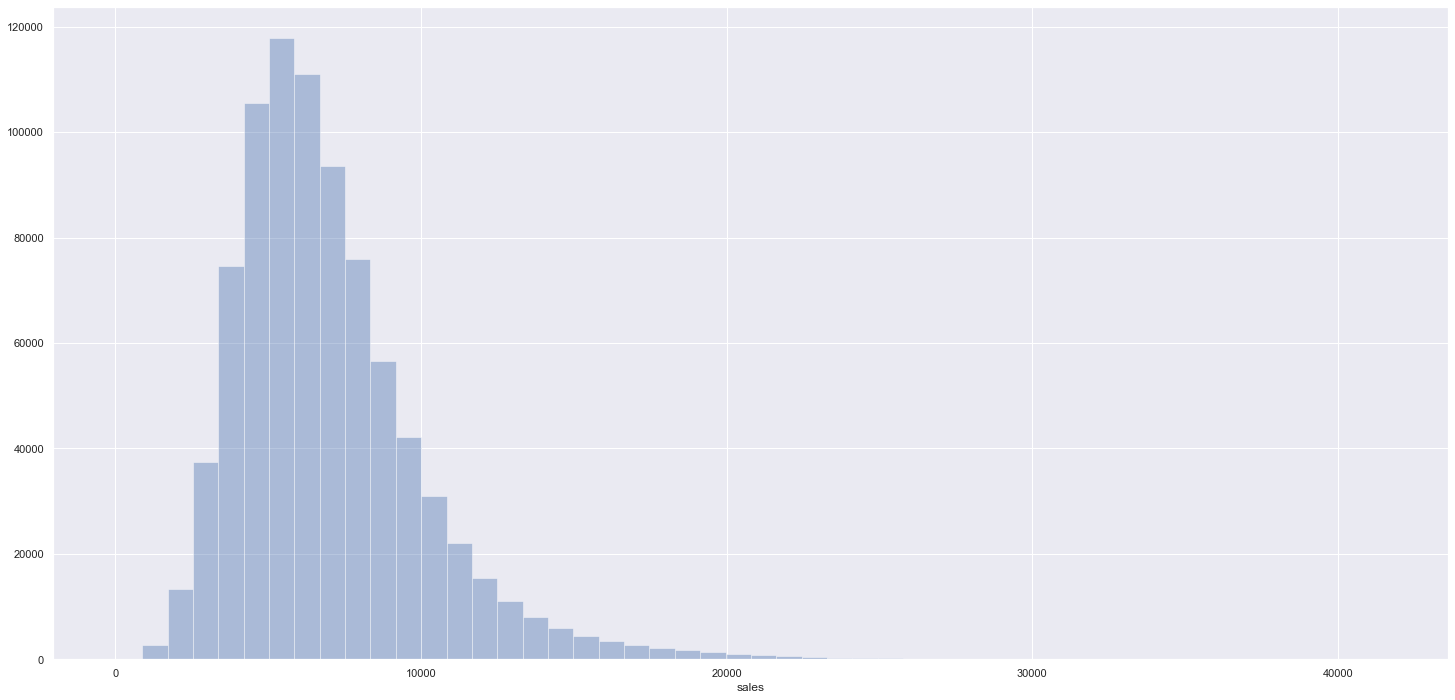

In [133]:
sns.distplot( df4['sales'], kde=False )
# displot é um plot de uma densidade de distribuição
# se quiser histograma colocar kde=False, mas não funcionou aqui. Windows?
# ??? Ficou sem diferença do plot anterior. Verificar

### 4.1.2 Numerical Variables

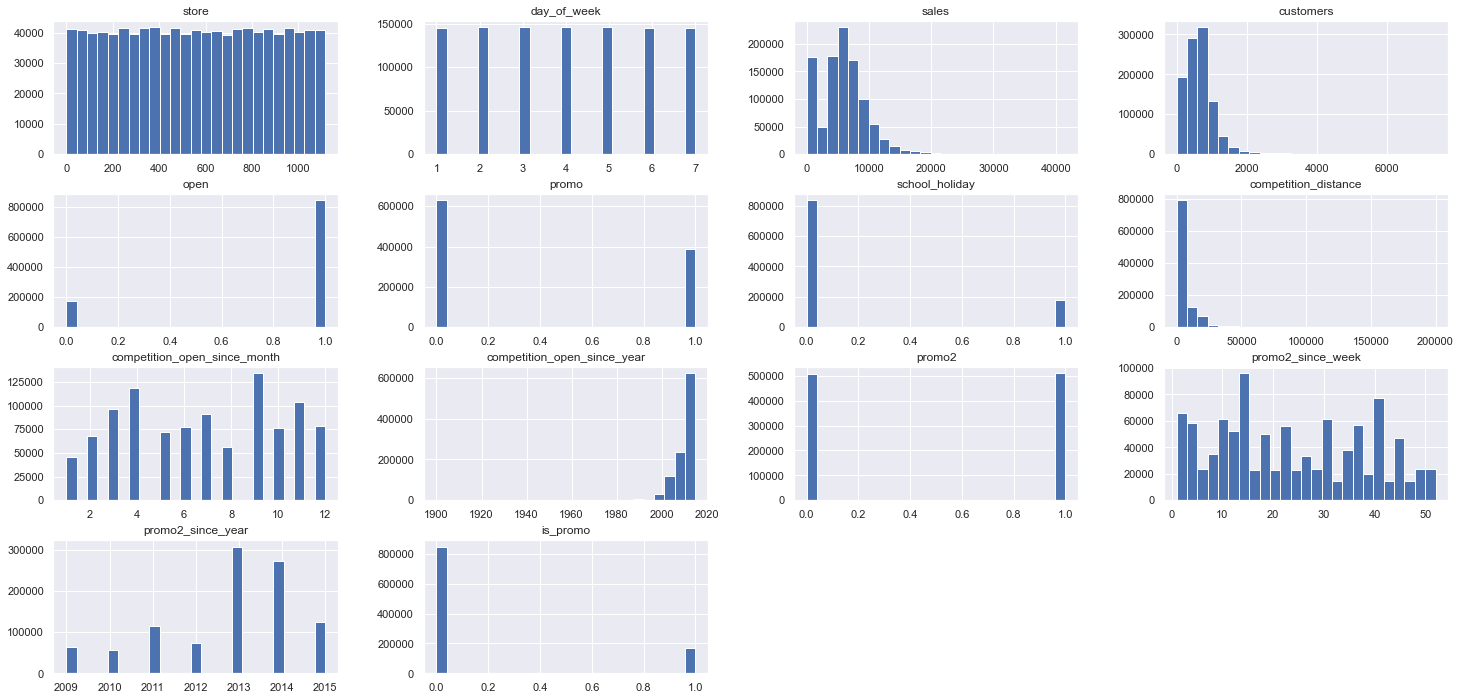

In [46]:
num_attributes.hist( bins=25 );
# os gráficos ficavam muito pequenos, mas usar a 'helper functions' do Meigarom solucionou

### 4.1.3 Categorical Variables

In [47]:
cat_attributes.head()
# Temos as seguintes variáveis categóricas:
# state_holiday
# store_type
# assortment
# (as outras duas usamos para derivar ou auxiliar)

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [48]:
# Quantas linhas (venda) eu tenho em cada uma das variáveis dentro da variavel categorica (pra ter uma ideia de volume, qual tipo de feriado impacta mais)
# Drop_duplicates pra gente ficar so com os tipos das variaveis categoricas originais (regular_day, public_holiday, easter_holiday, christmas)
# Removing duplicates is an essential skill to get accurate counts because you often don't want to count the same thing multiple times.
df4["state_holiday"].drop_duplicates()
# Lembrando que: StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. 
# Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

# ??? pq 0 em regular_day?? nao seria mais? pq pra regular_day é 0? e pros outros são letras e ai ele conta? Acho que tem a ver com isso..
# o cat_attributes foi definido antes de renomear o a,b,c e 0 para os nomes

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

<AxesSubplot:xlabel='state_holiday', ylabel='count'>

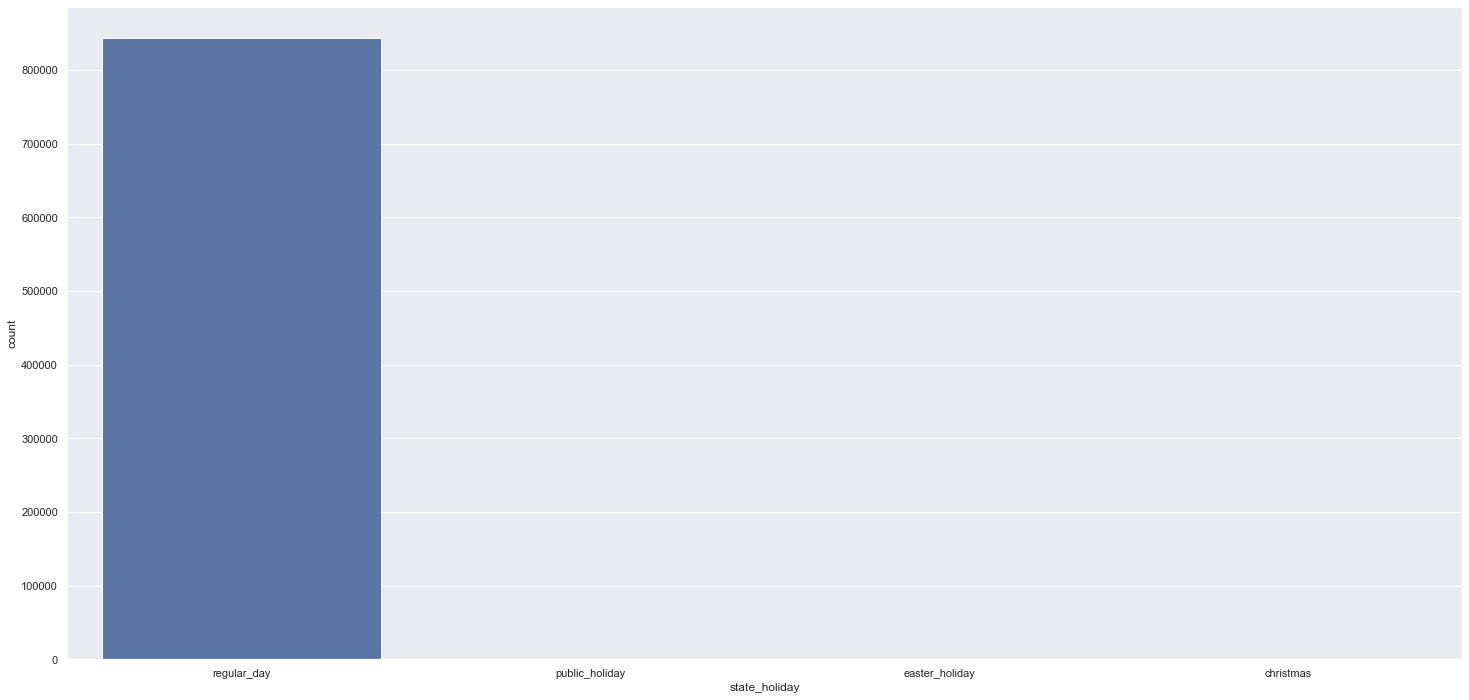

In [49]:
sns.countplot( df4["state_holiday"] )

<AxesSubplot:xlabel='state_holiday', ylabel='count'>

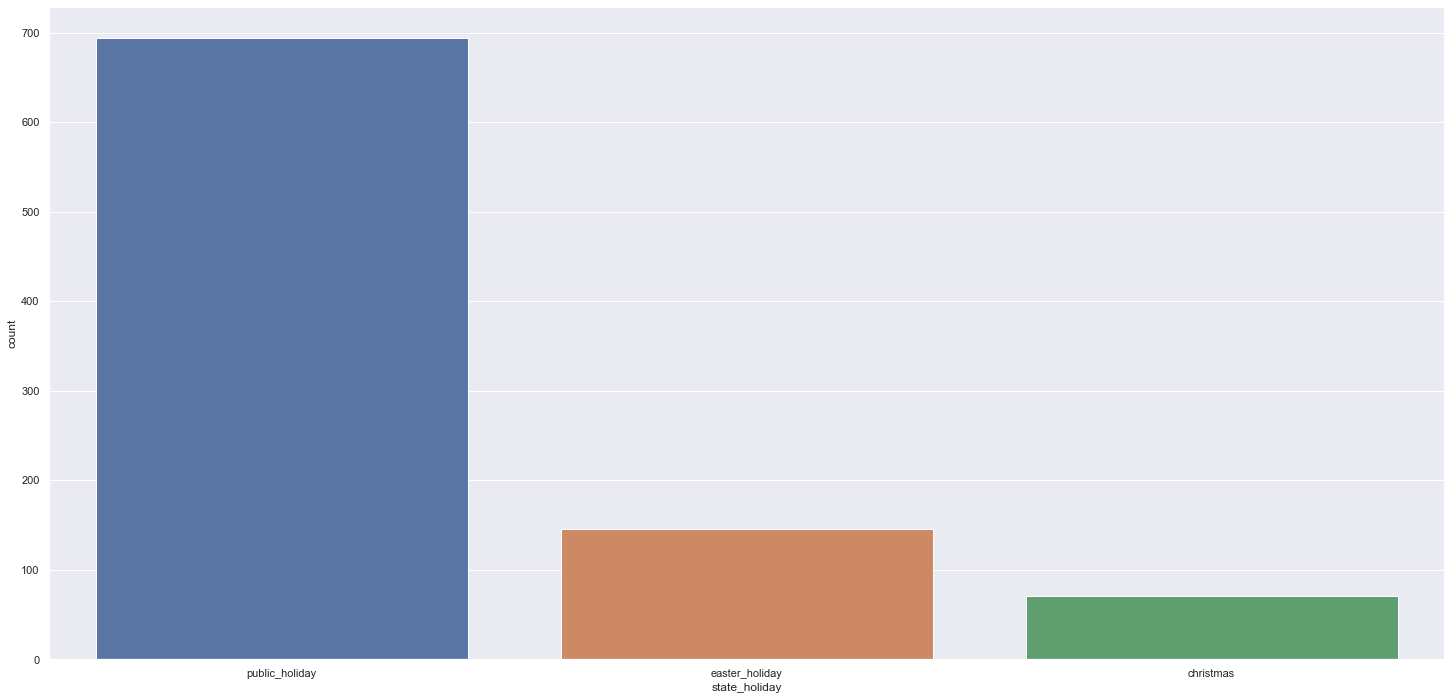

In [50]:
# state_holiday

# Para enxergarmos melhor vamos filtrar os dias regulares ja que ele é mtttt maior que os outros
# df4["state_holiday"] != 'regular_day'
# quero filtrar todas as linhas e colunas e vou guardar em uma variável chamada a
a = df4[df4["state_holiday"] != 'regular_day']
# o a é um dataframe que não tem "regular_day" na coluna state_holiday

# sns.countplot(a) - naaao! atenção
sns.countplot( a["state_holiday"] )

<AxesSubplot:xlabel='sales', ylabel='Density'>

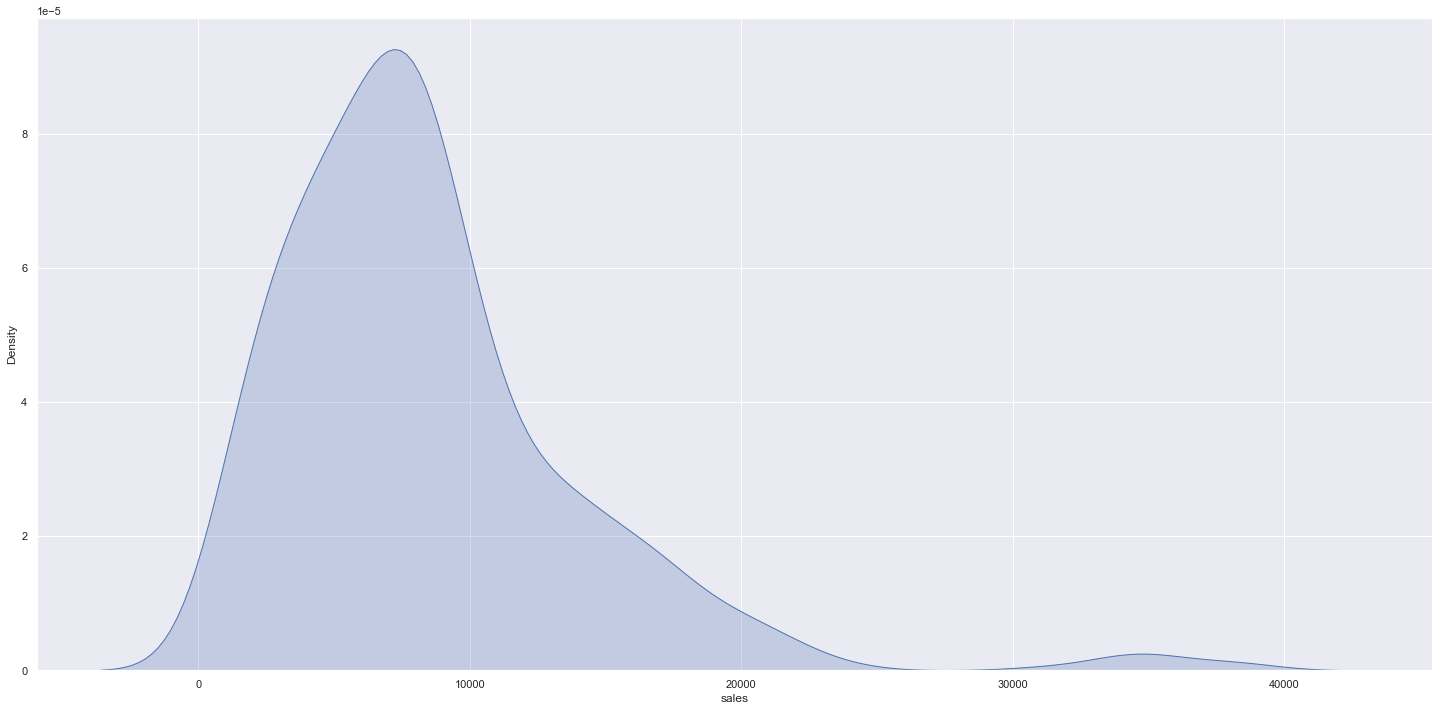

In [51]:
# Vimos que o public_holiday é o que tem mais vendas...

# df4["state_holiday"] = "public_holiday"
# do public_holiday quero so a variavel venda, entao vou passar todas as vendas do feriado "public_holiday" como argumento pra um método chamado
# kdeplot tambem da classe Seaborn e tambem vamos passar 2 outros inputs, label e shade=True

# atenção!!! método pede argumento que é com (), a classe pede um método com .
sns.kdeplot( df4[df4["state_holiday"] == "public_holiday"]["sales"], label="public_holiday", shade=True )

# Então temos a seguinte distribuição de vendas para o feriado "public_holiday"

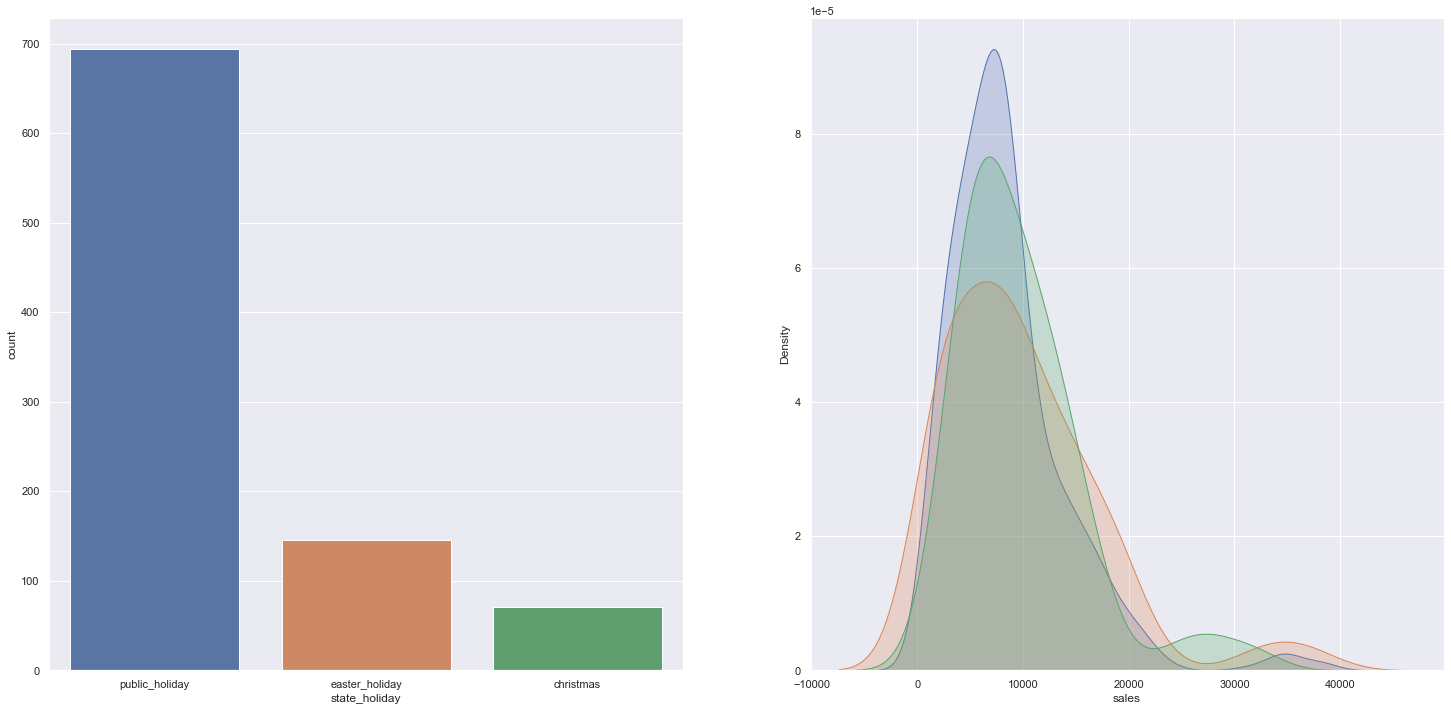

In [52]:
# Agora vamos dar uma olhada nos outros feriados (count e distribuição) 

plt.subplot(1,2,1)
a = df4[df4["state_holiday"] != "regular_day"]
sns.countplot( a["state_holiday"] );

plt.subplot(1,2,2)
sns.kdeplot( df4[df4["state_holiday"] == "public_holiday"]["sales"], label="public_holiday", shade=True );
sns.kdeplot( df4[df4["state_holiday"] == "easter_holiday"]["sales"], label="easter_holiday", shade=True );
sns.kdeplot( df4[df4["state_holiday"] == "christmas"]["sales"], label="christmas", shade=True );


In [53]:
df4["store_type"].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

In [54]:
df4["assortment"].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

<AxesSubplot:xlabel='sales', ylabel='Density'>

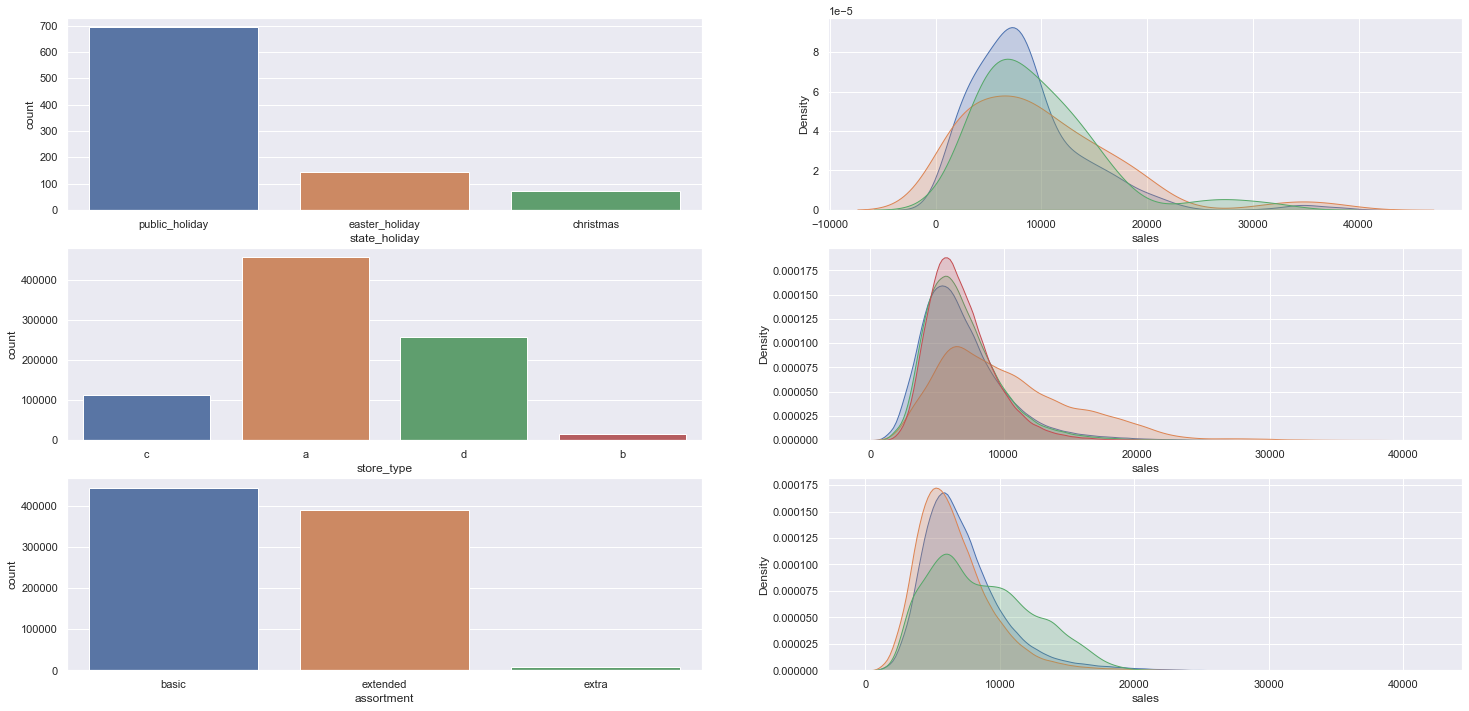

In [55]:
# Agora vamos dar uma olhada nesses graficos (count e distribuição) para as outras variaveis categoricas também

# state_holiday
plt.subplot(3,2,1)
a = df4[df4["state_holiday"] != 'regular_day']
sns.countplot( a["state_holiday"] )

plt.subplot(3,2,2)
sns.kdeplot( df4[df4["state_holiday"] == "public_holiday"]["sales"], label="public_holiday", shade=True )
sns.kdeplot( df4[df4["state_holiday"] == "easter_holiday"]["sales"], label="easter_holiday", shade=True )
sns.kdeplot( df4[df4["state_holiday"] == "christmas"]["sales"], label="christmas", shade=True )

# store_type
plt.subplot(3,2,3)
sns.countplot( df4["store_type"] )

plt.subplot(3,2,4)
sns.kdeplot( df4[df4["store_type"] == "a"]["sales"], label="a", shade=True )
sns.kdeplot( df4[df4["store_type"] == "b"]["sales"], label="b", shade=True )
sns.kdeplot( df4[df4["store_type"] == "c"]["sales"], label="c", shade=True )
sns.kdeplot( df4[df4["store_type"] == "d"]["sales"], label="d", shade=True )

# assortment
plt.subplot(3,2,5)
sns.countplot( df4["assortment"] )

plt.subplot(3,2,6)
sns.kdeplot( df4[df4["assortment"] == "extended"]["sales"], label="extended", shade=True )
sns.kdeplot( df4[df4["assortment"] == "basic"]["sales"], label="basic", shade=True )
sns.kdeplot( df4[df4["assortment"] == "extra"]["sales"], label="extra", shade=True )


In [56]:
# Para instalar extensão sugerida pelo Meigarom para facilitar visualização de erros e tambem nao mostrar codigos que geraram gráficos
# !pip install ipyparallel

## 4.2. Bivariate Analysis

### Qual a força que determinada variável tem em afetar a variável resposta?

### H.1 Stores with greater assortment should sell more.

**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.

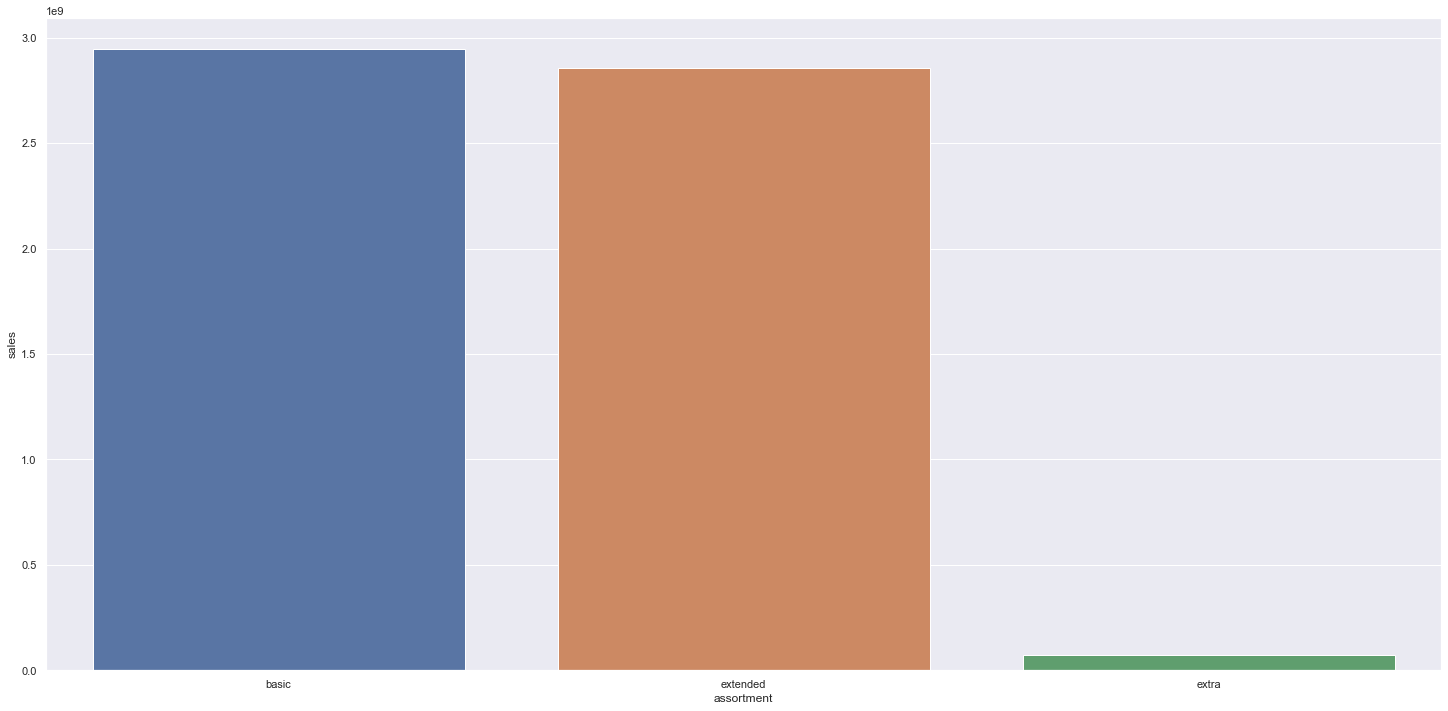

In [57]:
# aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()

# Queremos pegar essas duas variáveis "assortment" e "sales" e vamos agrupar (groupby) as vendas por cada tipo de assortment e depois somar (sum) para ver o valor final
# resetar o index para virar um dataframe para facilitar visualização e guardar o resultado em uma variável auxiliar aux1
# aux1 = df4["assortment", "sales"].groupby("assortment").sum().reset_index() - atenção!

aux1 = df4[["assortment", "sales"]].groupby("assortment").sum().reset_index()

# Para visualizar podemos usar um barplot, método da classe Seaborn. ; no final para ele nao ficar plotando texto
sns.barplot( x="assortment", y="sales", data=aux1 );

# aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week','assortment'] ).sum().reset_index()
# aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

# aux3 = aux2[aux2['assortment'] == 'extra']
# aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()

**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.
Após verificar isso, podemos avaliar a questão temporal. Houve alguma mudança de vendas ao longo do tempo? Será que as lojas "extra" vendiam muito e isso foi mudando ao longo do tempo e a soma ficou baixa?

In [58]:
# Agora incluindo o "yeak_week" pois queremos a soma de todas as vendas por assortment por semanas do ano (tempo) e gora vamos agrupar por year_week e assortment
aux2 = df4[["year_week", "assortment", "sales"]].groupby(["year_week","assortment"]).sum().reset_index()

aux2.head()

,year_week,assortment,sales
0,2013-00,basic,13434262
1,2013-00,extended,12425669
2,2013-00,extra,269404
3,2013-01,basic,26007250
4,2013-01,extended,22917693


A primeira linha demonstrada acima temos a quantidade de vendas do tipo assortment basic nessa data (semana) e repetimos 3 linhas pois temos 3 tipos de assortment. Para fazer o plot de uma linha (3 linhas, cada uma representando um tipo de assortment), o ideal é fazer um pivot dessa coluna com cada linha que fosse única em termos de ano e semana. O assortment viraria colunas e dentro dessas colunas teríamos os valores das vendas.

In [59]:
# Index = granularidade das linhas
aux3 = aux2.pivot( index= "year_week" , columns= "assortment",values= "sales" )
aux3.head()

assortment,basic,extended,extra
year_week,,,
2013-00,13434262,12425669,269404
2013-01,26007250,22917693,350279
2013-02,17970974,16029584,377207
2013-03,24392076,21243431,404662
2013-04,19972891,18130077,363061


<AxesSubplot:xlabel='year_week'>

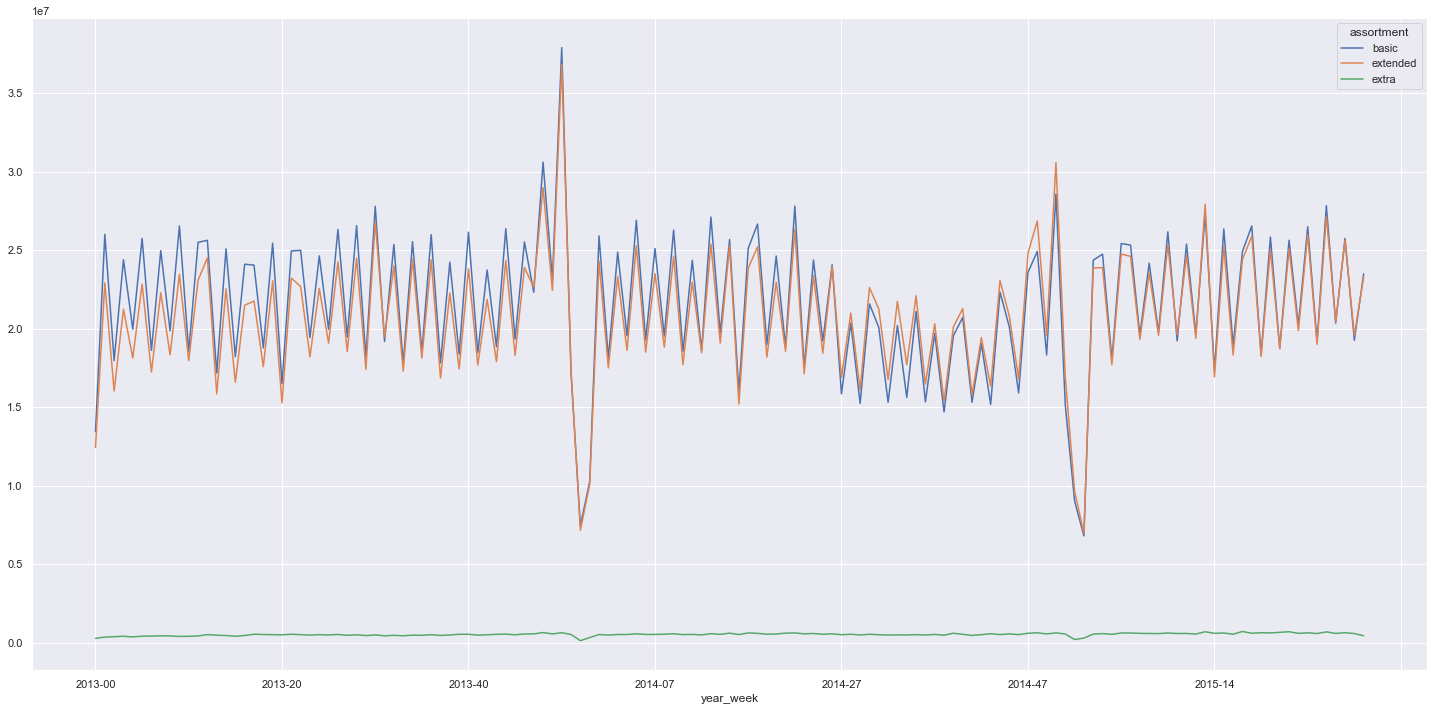

In [60]:
aux3.plot()

Basic e extended possuem praticamente o mesmo comportamento. Vamos dar uma olhada melhor no extra para ver se é linear ou se tem algum tipo de comportamento.

<AxesSubplot:xlabel='year_week'>

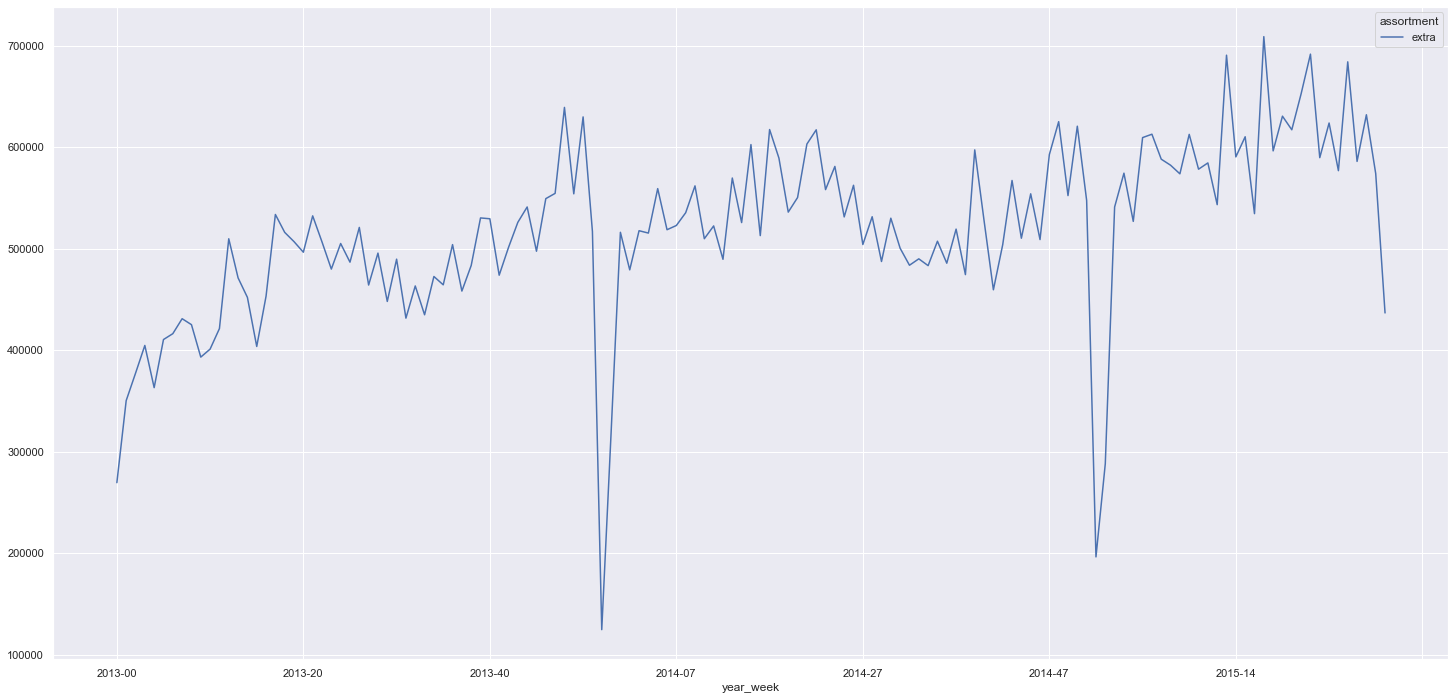

In [61]:
# Filtrando o aux2 para pegar só o assortment extra
# aux2["assortment"] == "extra"
# Quero todas as linhas e colunas:
# aux2[aux2["assortment"] == "extra"]
# E fazer o pivot novamente:

aux2[aux2["assortment"] == "extra"].pivot( index= "year_week" , columns= "assortment",values= "sales" ).plot()

O assortment "extra" tem comportamento sim ao longo do tempo. Sempre preste atenção na ordem de grandeza dos eixos.

### H.2 Stores with more competitors nearby should sell less.

**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS.

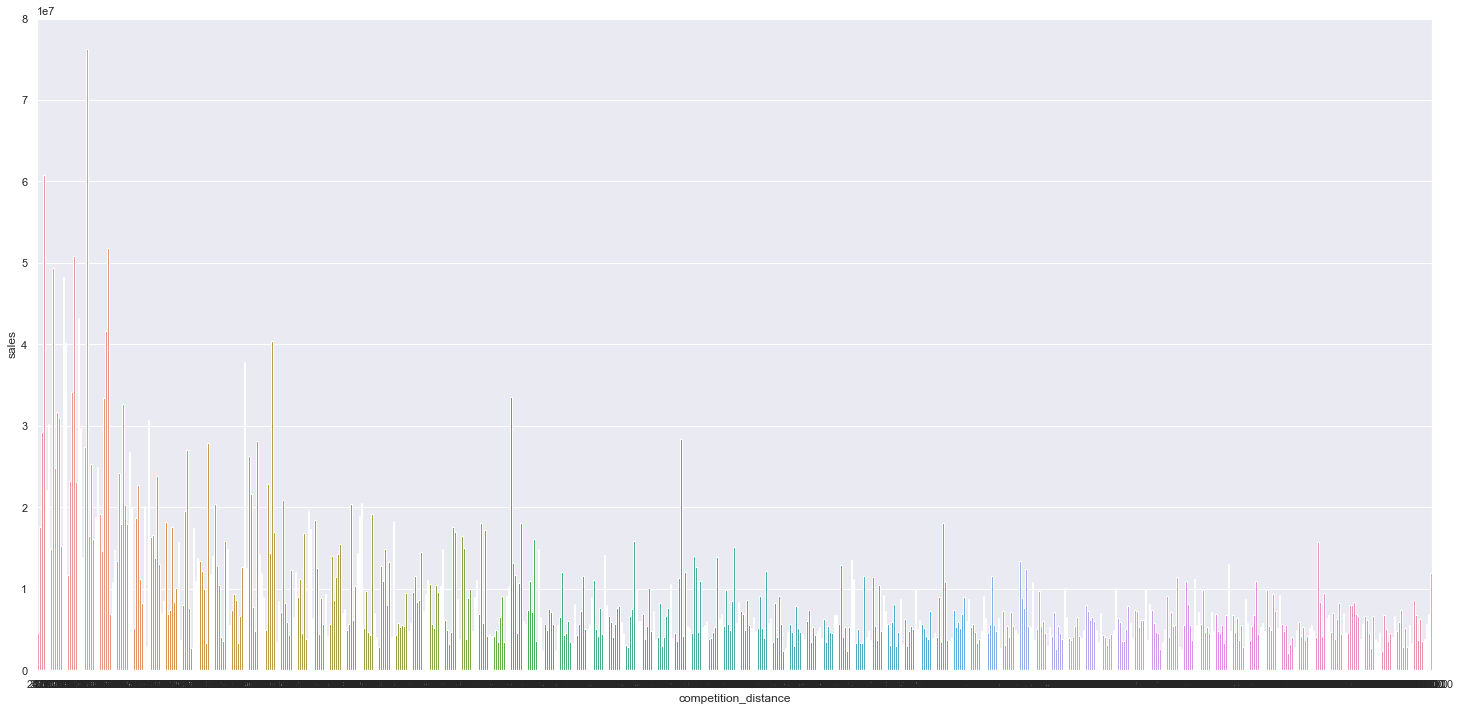

In [62]:
#Vamos pegar agora as duas colunas de interesse. E vamos tentar ver as vendas de acordo com a distancia dos consumidores, agrupando por "competition_distance"
# Depois de agrupar vamos somar e resetar o index
aux1 = df4[["competition_distance", "sales"]].groupby( "competition_distance" ).sum().reset_index()

# Nao esquecer o ; no final para que ele não fique mostrando informações a mais
sns.barplot(x="competition_distance", y="sales", data=aux1);

Assim não dá pra ver nada! E se agruparmos a competition_distance? Para isso vamos usar o bin! (bin = grupo de valores)

In [63]:
# Criando bins que vao ser arrays dessa forma, de 0 a 20000 em intervalor de 1000 em 1000 (os numeros sao arbitrarios)
bins = np.arange (0, 20000, 1000)

# Como saber em qual grupo desses bins determinada "competition_distance" se encaixa?

# pd.cut( aux1["competition_distance"], bins=bins) e vamos colocar em uma nova coluna "competition_distance_binned"

aux1["competition_distance_binned"] = pd.cut( aux1["competition_distance"], bins=bins)

In [64]:
aux1.sample(5)

,competition_distance,sales,competition_distance_binned
203,2330.0,10024132,"(2000, 3000]"
494,10800.0,6190043,"(10000, 11000]"
396,6480.0,4834459,"(6000, 7000]"
383,5980.0,11149203,"(5000, 6000]"
411,6930.0,5050619,"(6000, 7000]"


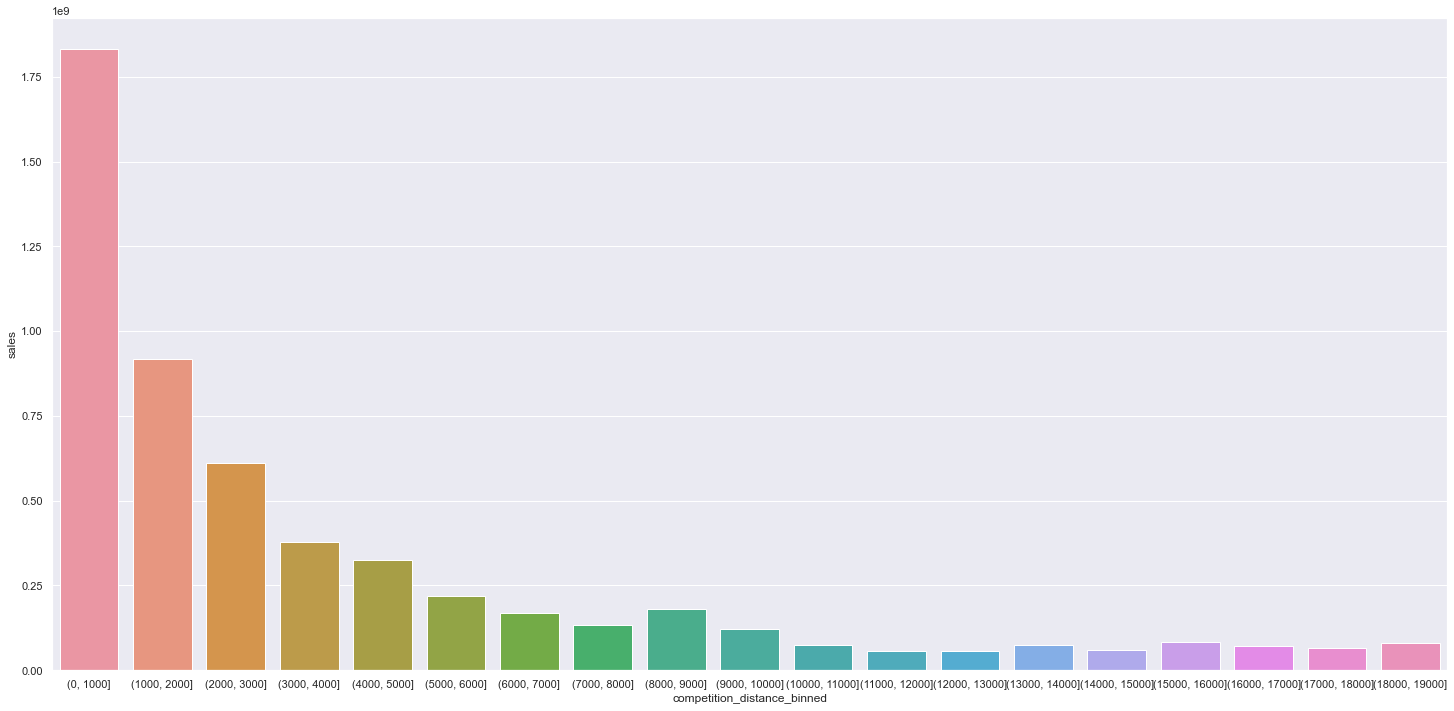

In [65]:
# Agora, antes de plotar temos que fazer a nova soma das vendas dentro dos grupos

aux2 = aux1[["competition_distance_binned", "sales"]].groupby( "competition_distance_binned" ).sum().reset_index()

sns.barplot(x="competition_distance_binned", y="sales", data=aux2);

Dessa forma, facilitou bastante a leitura do gráfico. Dessa forma podemos avaliar melhor o resultado. O senso comum poderia pensar que com muitos competidores mais próximos haveria menos vendas, mas o resultado observado foi exatamente o oposto. Esse é um insight!

Vamos fazer mais algumas análises para tentar ter um feeling se essa variável será importante para o modelo...

Dica: se temos dados muito granulares e fica dificil de enxergar com barras ou linhas, pode ser uma boa ideia usar um scatter plot.

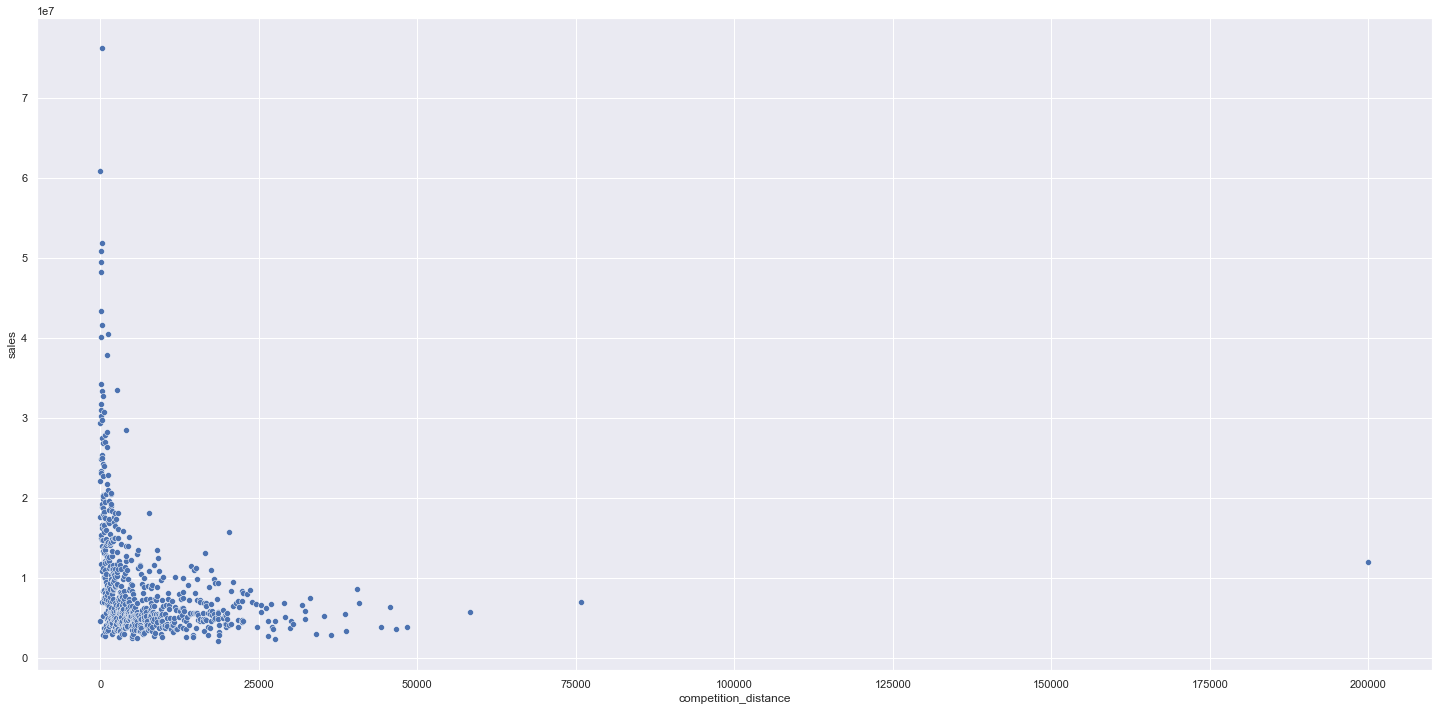

In [66]:
sns.scatterplot ( x="competition_distance", y="sales", data=aux1);

Dessa forma, também podemos ver que as vendas estão concentradas em lojas com competidores próximos.

Também podemos criar um gráfico que mede a força da correlação entre a "competition_distance" e as vendas.

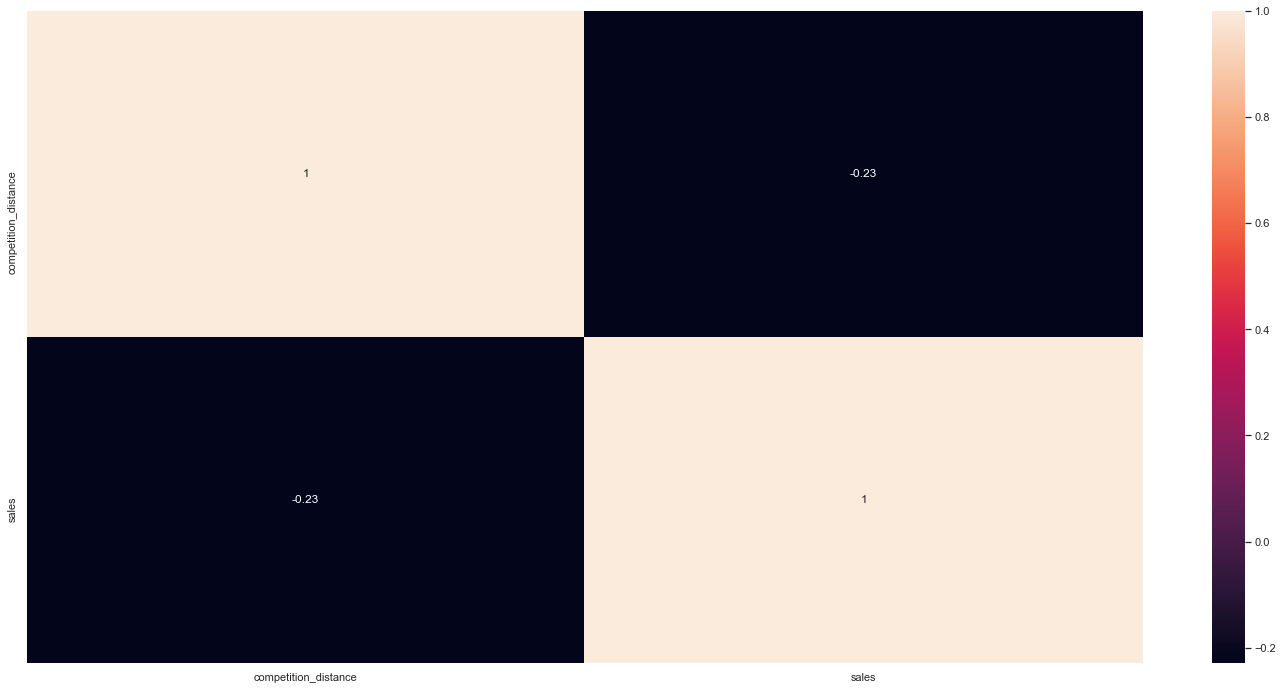

In [67]:
# Vamos usar um método da classe Seaborn chamado heatmap e o argumento vai ser a correlação. annot=True pois queremos ver essa correlação
# Não esquecer do ; para ele não plotar os textos...

sns.heatmap ( aux1.corr( method="pearson" ), annot=True);

A correlação é de -0.23. A correlação vai de 1 até -1, quanto mais próximo de 0, mais fraca é a correlação e quanto mais próximo de 1 ou -1, mais forte a correlação. O valor negativo significa que, nesse caso, quanto menos distante o competidor está, maior a venda.

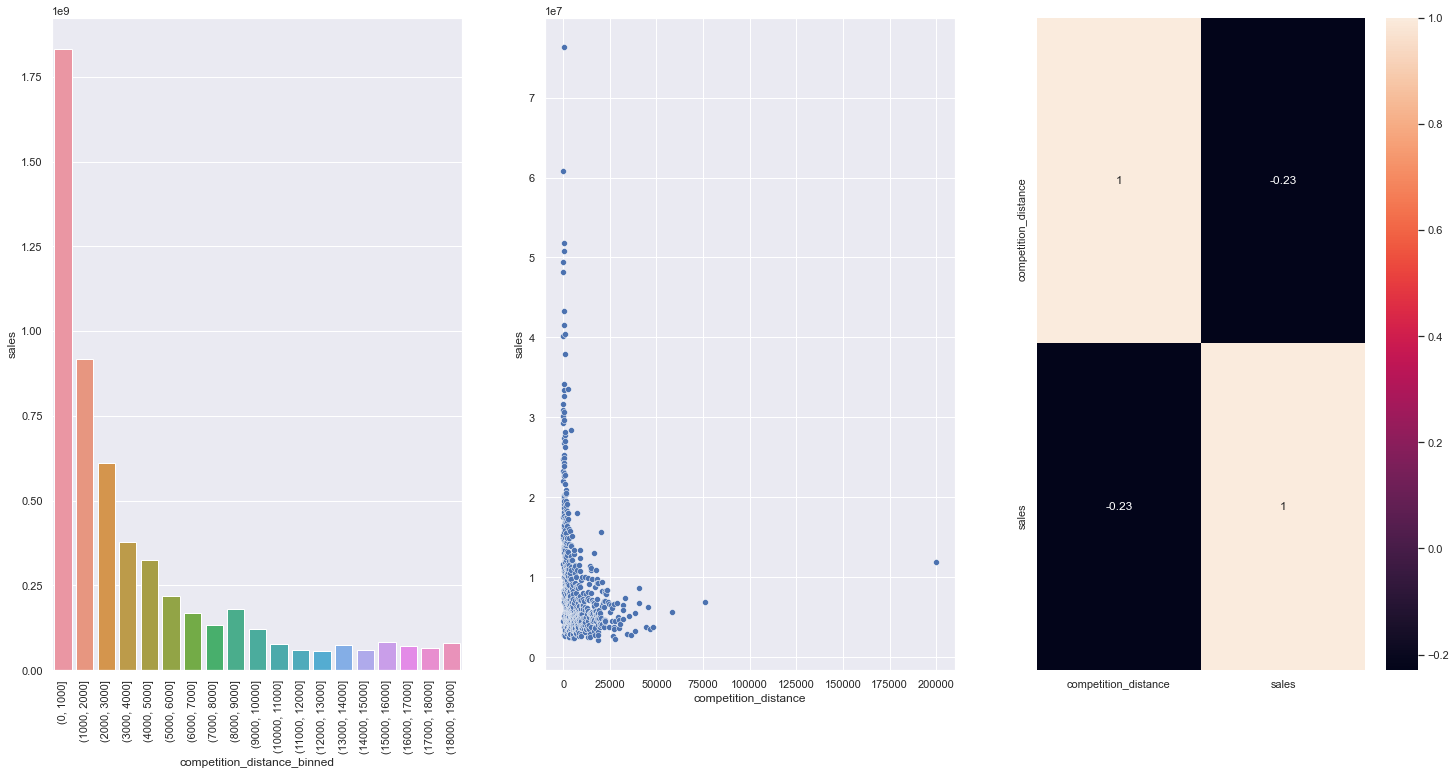

In [68]:
# Colocando os 3 gráficos acima em um mesmo snippet:

plt.subplot(1,3,1)
sns.barplot(x="competition_distance_binned", y="sales", data=aux2);
# quando foi plotado assim, a legenda do eixo x ficou sobreposta, para consertar: 
plt.xticks( rotation= 90 )

plt.subplot(1,3,2)
sns.scatterplot ( x="competition_distance", y="sales", data=aux1);

plt.subplot(1,3,3)
sns.heatmap ( aux1.corr( method="pearson" ), annot=True);

### H.3 Stores with competitors for longer should sell more.

**FALSE** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

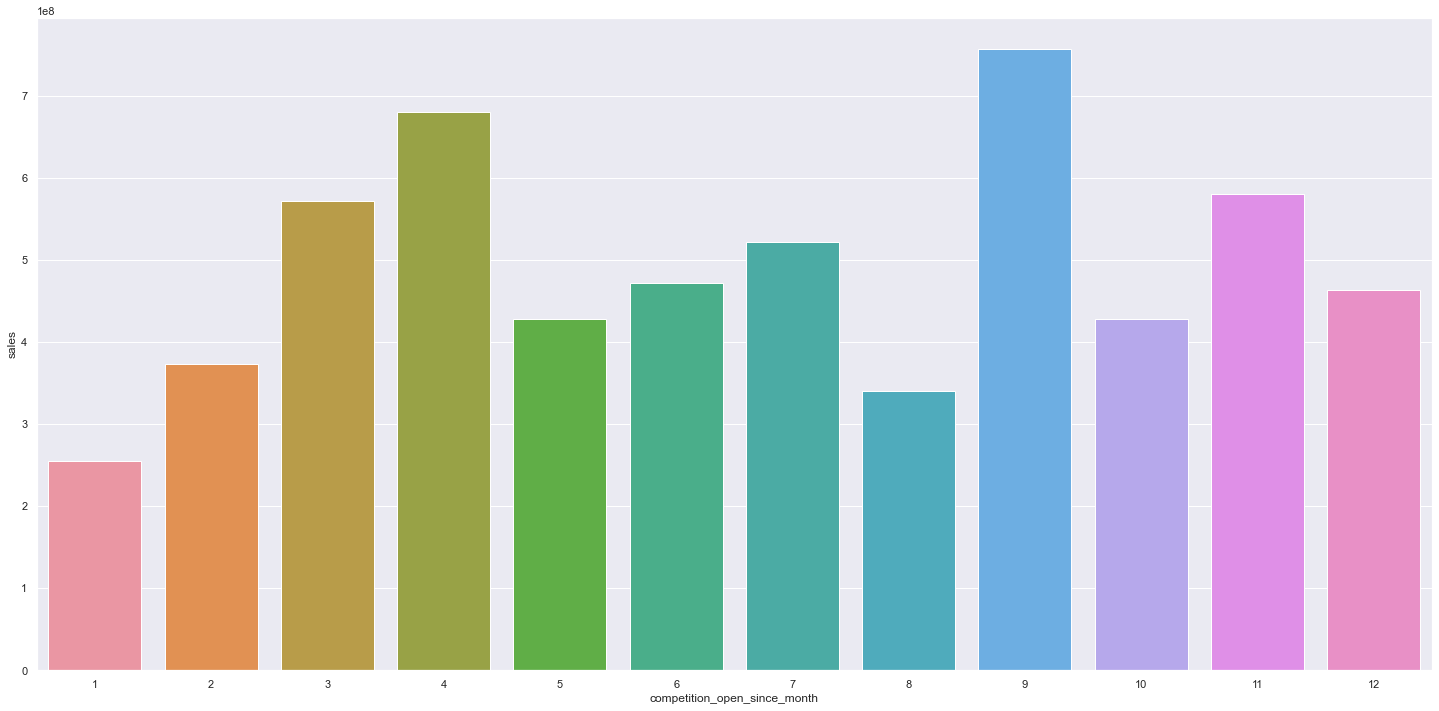

In [69]:
aux1 = df4[["competition_open_since_month", "sales"]].groupby("competition_open_since_month").sum().reset_index()
sns.barplot( x="competition_open_since_month", y="sales", data=aux1);

Queremos saber a relação de tempo que o competidor está aberto com as vendas, e o gráfico acima não nos ajuda nisso...

Para isso vamos usar uma variável que derivamos lá em cima: "competition_time_month"

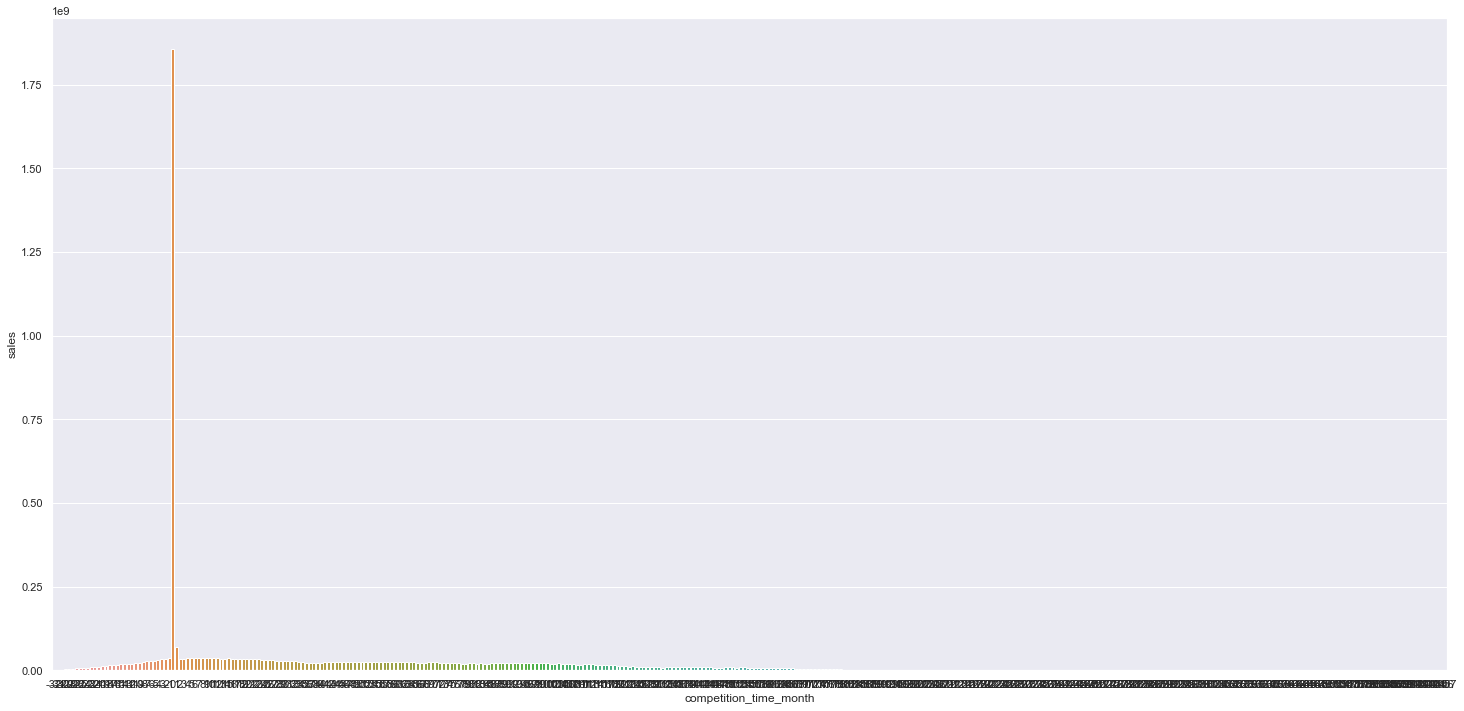

In [70]:
aux1 = df4[["competition_time_month", "sales"]].groupby("competition_time_month").sum().reset_index()
sns.barplot( x="competition_time_month", y="sales", data=aux1);

Não conseguimos enxergar nada... Para melhorar isso podemos criar um filtro!

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150]),
 [Text(0, 0, '-32'),
  Text(1, 0, '-31'),
  Text(2, 0, '-30'),
  Text(3, 0, '-29'),
  Text(4, 0, '-28'),
  Text(5, 0, '-27'),
  Text(6, 0, '-26'),


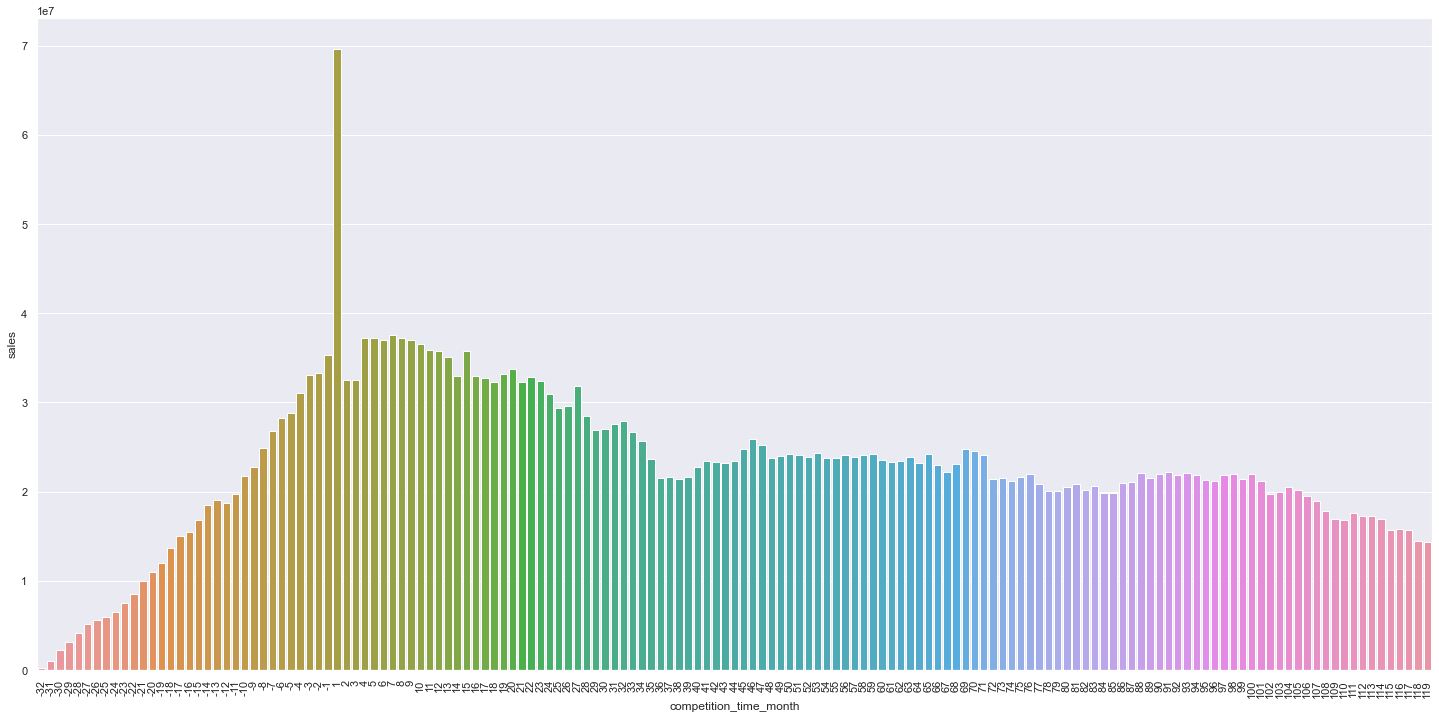

In [71]:
# Quero olhar só os primeiros 120 meses de competição e filtrar os competidores que tem tempo de competição = 0
# Filtros:
# ( aux1["competition_time_month"] < 120 ) & ( aux1["competition_time_month"] != 0 )

# Quero todas as linhas e colunas disso e coloco na variavel aux2
aux2 = aux1[( aux1["competition_time_month"] < 120 ) & ( aux1["competition_time_month"] != 0 )];

sns.barplot( x="competition_time_month", y="sales", data=aux2 );
plt.xticks( rotation = 90)

# ??? Pq ficou mostrando esse array?

A variável "competition_time_month" derivada significa o valor da venda agora ("date") menos a data que o competidor abriu. Se o competidor abriu há 6 meses e estou vendendo agora, tenho valor positivo. Se eu to vendendo agora e sei que o competidor vai abrir daqui a 4 meses, tenho valores negativos. Quanto mais o valor da "competition_time_month" se aproxima de 0, maior as vendas! Quanto mais recente a competição, maior a venda! Eitcha. Também contraditório ao senso comum.

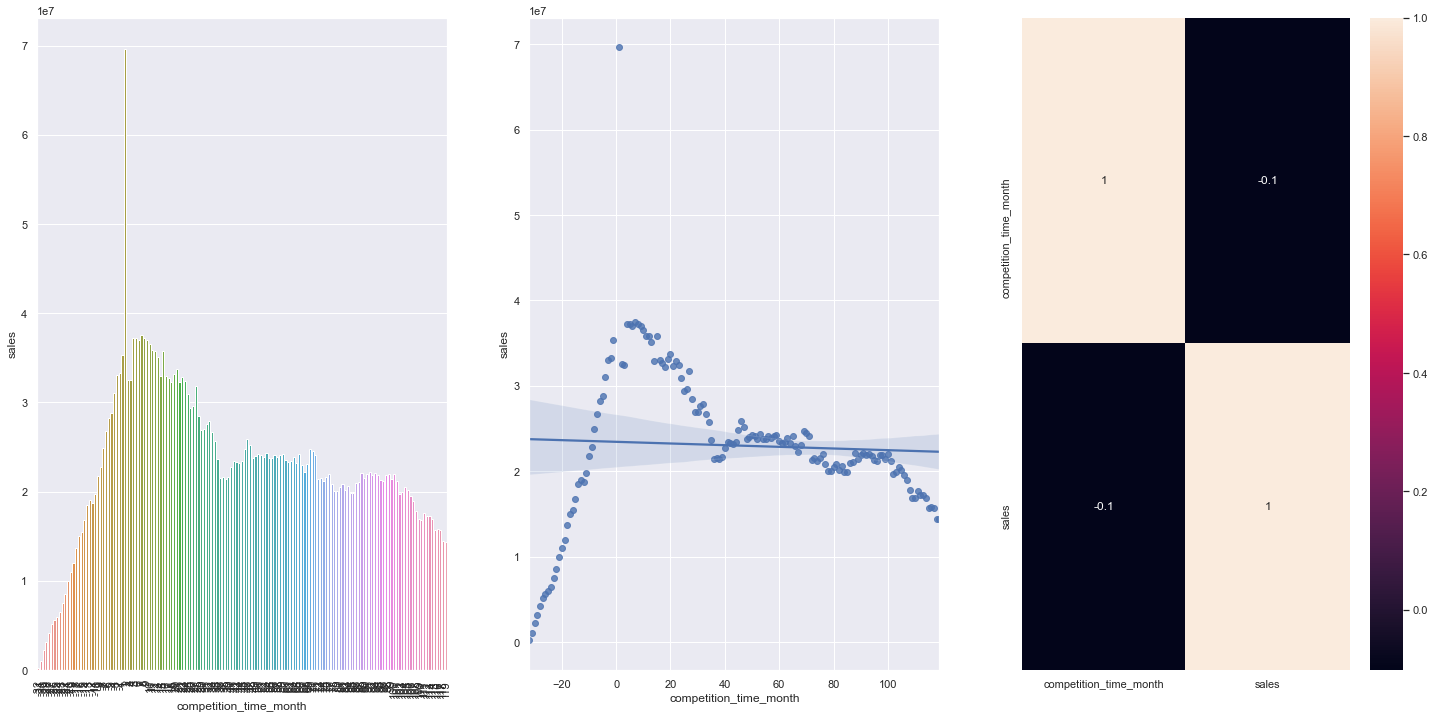

In [72]:
plt.subplot( 1, 3, 1 )
aux1 = df4[["competition_time_month", "sales"]].groupby( "competition_time_month" ).sum().reset_index()
aux2 = aux1[( aux1["competition_time_month"] < 120 ) & ( aux1["competition_time_month"] != 0 )]
sns.barplot( x="competition_time_month", y="sales", data=aux2 );
plt.xticks( rotation=90 );

# Regplot mesma coisa que barplot mas ele tambem plot uma tendencia
plt.subplot( 1, 3, 2 )
sns.regplot( x="competition_time_month", y="sales", data=aux2 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method="pearson"), annot=True );

Correlação de -0.1. Desvalidamos a hipótese e a variável vai ser relevante pois não temos uma correlação tão próxima de 0 assim.

### H4. Stores with active sales for longer should sell more.

**FALSA** Lojas com promoções ativas por mais tempo vendem menos depois de um certo período de promoção.

In [73]:
# Granularidade: cada linha tenho vendas por dia por loja
df4.sample(5)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
57262,398,3,2015-06-10,3765,0,regular_day,0,c,extended,1540.0,6,2015,1,1,2012,0,2015,6,10,24,2015-23,2015-06-01,0,2011-12-26,180
645070,271,6,2013-11-30,2883,0,regular_day,0,a,basic,420.0,11,2013,1,14,2011,0,2013,11,30,48,2013-47,2013-11-01,0,2011-03-28,139
578039,140,3,2014-01-29,7013,0,regular_day,0,a,extended,1090.0,7,2010,1,1,2013,1,2014,1,29,5,2014-04,2010-07-01,43,2012-12-31,56
375512,901,2,2014-08-05,7279,1,regular_day,1,a,extended,3170.0,4,2014,0,32,2014,0,2014,8,5,32,2014-31,2014-04-01,4,2014-08-04,0
965827,1023,6,2013-02-16,6214,0,regular_day,0,c,basic,3740.0,2,2002,1,14,2011,0,2013,2,16,7,2013-06,2002-02-01,134,2011-03-28,98


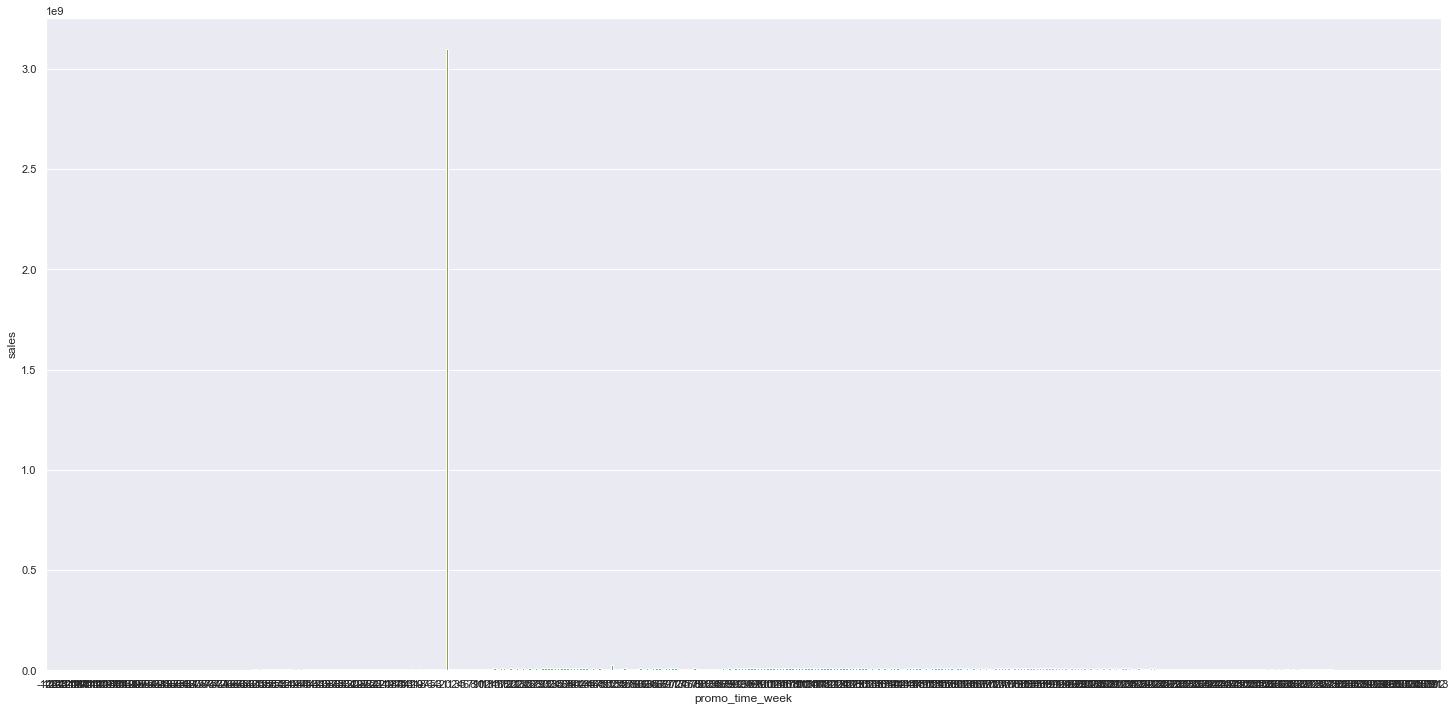

In [74]:
# Vamos usar a "promo_time_week" que derivamos (da variável "date" - "promo_since")
# A promo2 deve ser uma promoção extendida. Se a promoção extendida começou quer dizer que a promoção tradicional acabou.
# Temos as possibilidades de valor positivo ou negativo para a variável "promo_time_week", em que:
# Valores negativos: se a venda ocorre no período tradicional de promoção (sem a promo2), no futuro posso entrar ou não em promo2, então a data de hoje - a data futura resulta em um valor negativo
# Valores positivos: se a venda ocorre no período de promoção extendida (na promo2), isso significa que a promoção extendida (promo2) já começou no passado e a data da venda hoje é a maior que a data do inicio da promo2
# ??? Dúvida: uma "promo_time_week" de 0 corresponde à promo2 ter sido iniciada na data da venda, certo?
aux1 = df4[["promo_time_week", "sales"]].groupby("promo_time_week").sum().reset_index()
sns.barplot( x="promo_time_week", y="sales", data=aux1);

Não conseguimos ver nada nesse gráfico! Podemos dar um zoom em determinada região, por exemplo (filtrar, agrupar...)

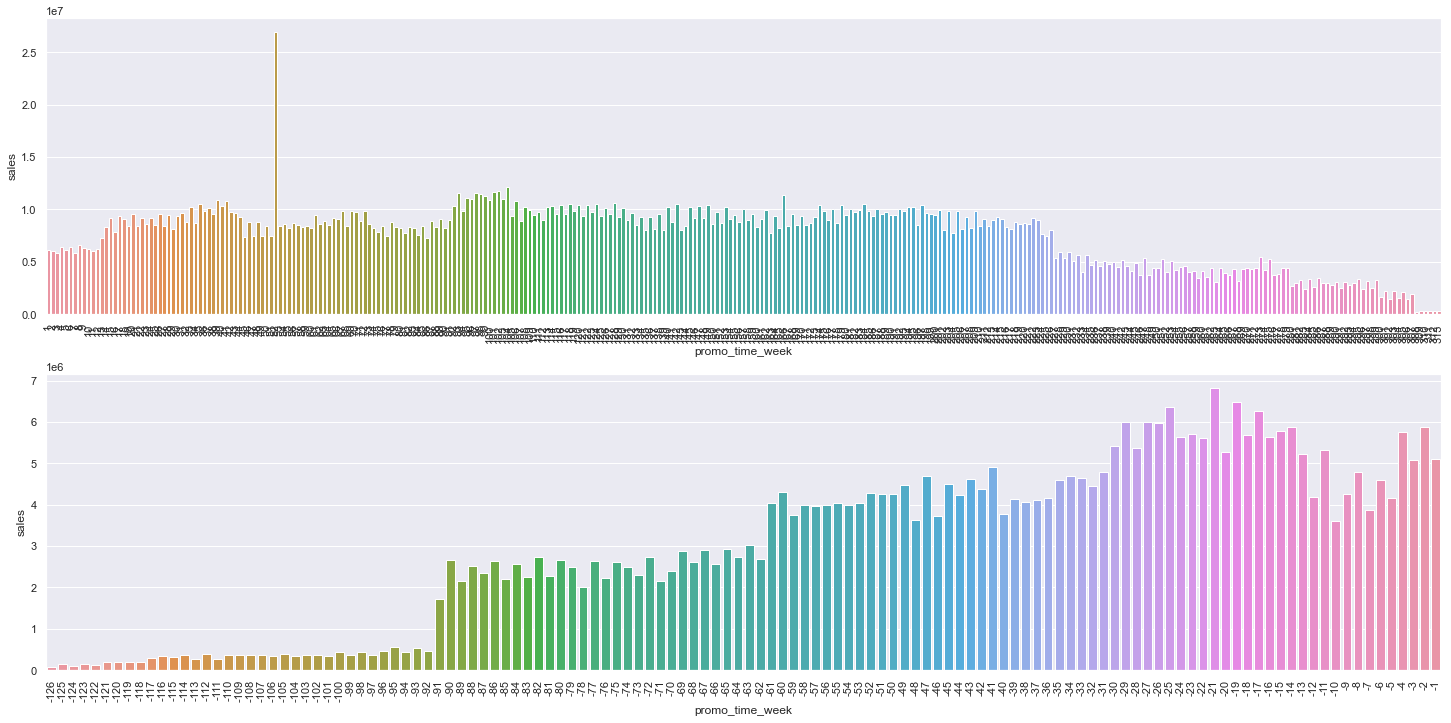

In [75]:
plt.subplot(2,1,1)
aux2 = aux1[aux1["promo_time_week"] > 0] # "promo_time_week" > 0 temos o período de promoção extendida (promo2)
sns.barplot( x="promo_time_week", y="sales", data=aux2);
plt.xticks( rotation=90 );

plt.subplot(2,1,2)
aux3 = aux1[aux1["promo_time_week"] < 0] # promo regular
sns.barplot( x="promo_time_week", y="sales", data=aux3);
plt.xticks( rotation = 90);

Não adianta promoção por um tempo muito longo, pois as vendas caem com o tempo.

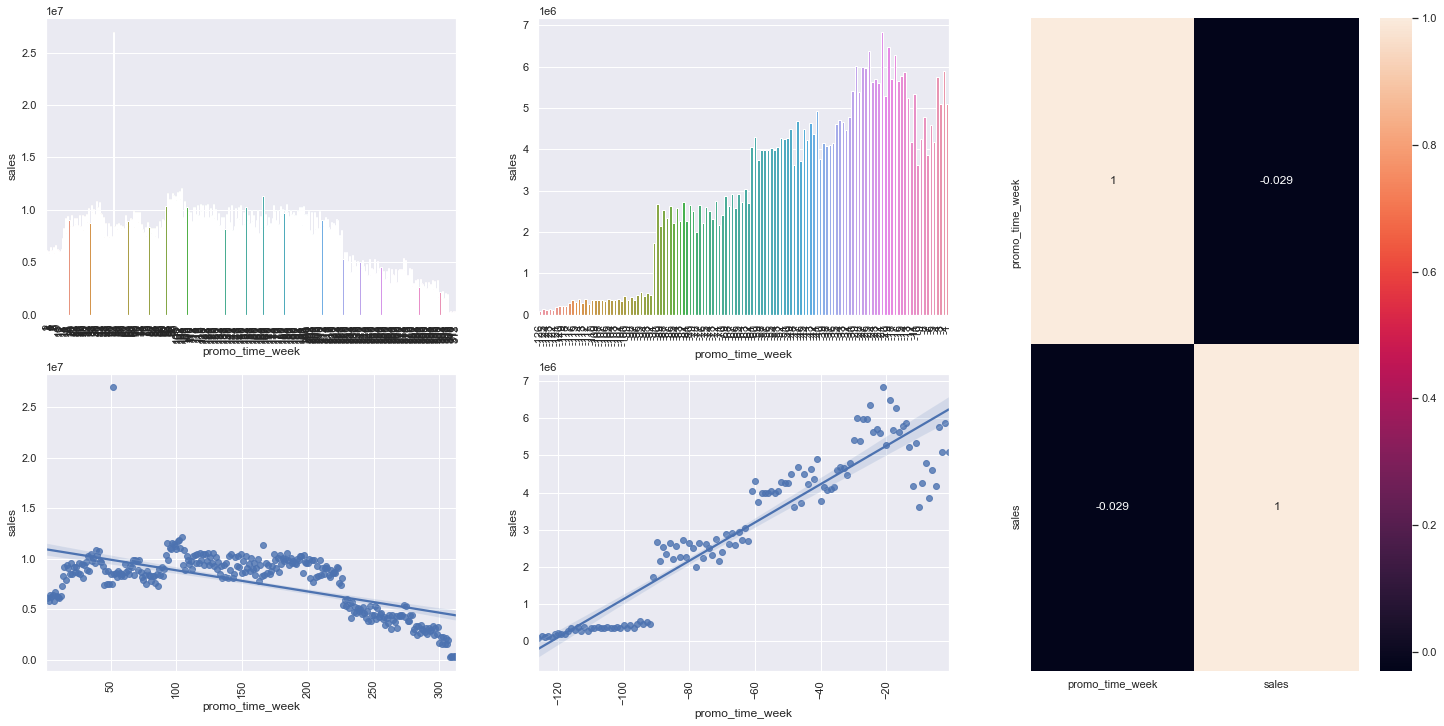

In [76]:
# Vamos plotar a tendencia e ver a força das correlações.
# Sem mudar nada, so substituir o barplot pelo regplot.
# O subplot faz sempre um grid em formato de quadrado, se quiser um grid mais personalizado usar o GridSpec()

grid = GridSpec(2,3) # linhas, colunas
# o subplot vai receber esse grid como argumento (grid começa do 0)

plt.subplot(grid[0,0])
aux2 = aux1[aux1["promo_time_week"] > 0] # "promo_time_week" > 0 temos o período de promoção extendida (promo2)
sns.barplot( x="promo_time_week", y="sales", data=aux2);
plt.xticks( rotation=90 );

plt.subplot(grid[0,1])
aux3 = aux1[aux1["promo_time_week"] < 0] # promo regular
sns.barplot( x="promo_time_week", y="sales", data=aux3);
plt.xticks( rotation = 90);

plt.subplot(grid[1,0])
aux2 = aux1[aux1["promo_time_week"] > 0] # "promo_time_week" > 0 temos o período de promoção extendida (promo2)
sns.regplot( x="promo_time_week", y="sales", data=aux2);
plt.xticks( rotation=90 );

plt.subplot(grid[1,1])
aux3 = aux1[aux1["promo_time_week"] < 0] # promo regular
sns.regplot( x="promo_time_week", y="sales", data=aux3);
plt.xticks( rotation = 90);
 
# Para encontrar a força da correlação:
# Pegamos os dados do aux1. As outras aux foram só para dar um zoom, mas para pensar no modelo temos que usar dados completos
# Queremos que esse plot ocupe as duas ultimas linhas
plt.subplot(grid[:,2])
sns.heatmap( aux1.corr( method="pearson"), annot=True );

Correlação de -0.029, muito fraca. Provavelmente devido a um longo período com valores mais constantes. Provavelmente, não será uma feature relevante para o modelo. Mas atente que essa feature pode ser relevante ao ser combinada com outra.

### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>


Hipótese bem similar à H4. Vamos deixar para o segundo ciclo do CRISP, pois teríamos que criar uma nova variável como "dias de promoção" e agrupar dias de promoção por loja e contabilizar. 

### H6. Stores with more consecutive sales should sell more.

**FALSA** Lojas com mais promoções consecutivas vendem menos.

Lojas que entraram em períodos consecutivos de promoção vendem mais do que as que não entram?

In [77]:
# Agora agrupando por 2 variáveis fornecemos uma lista como argumento do groupby
df4[["promo", "promo2", "sales"]].groupby(["promo","promo2"]).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


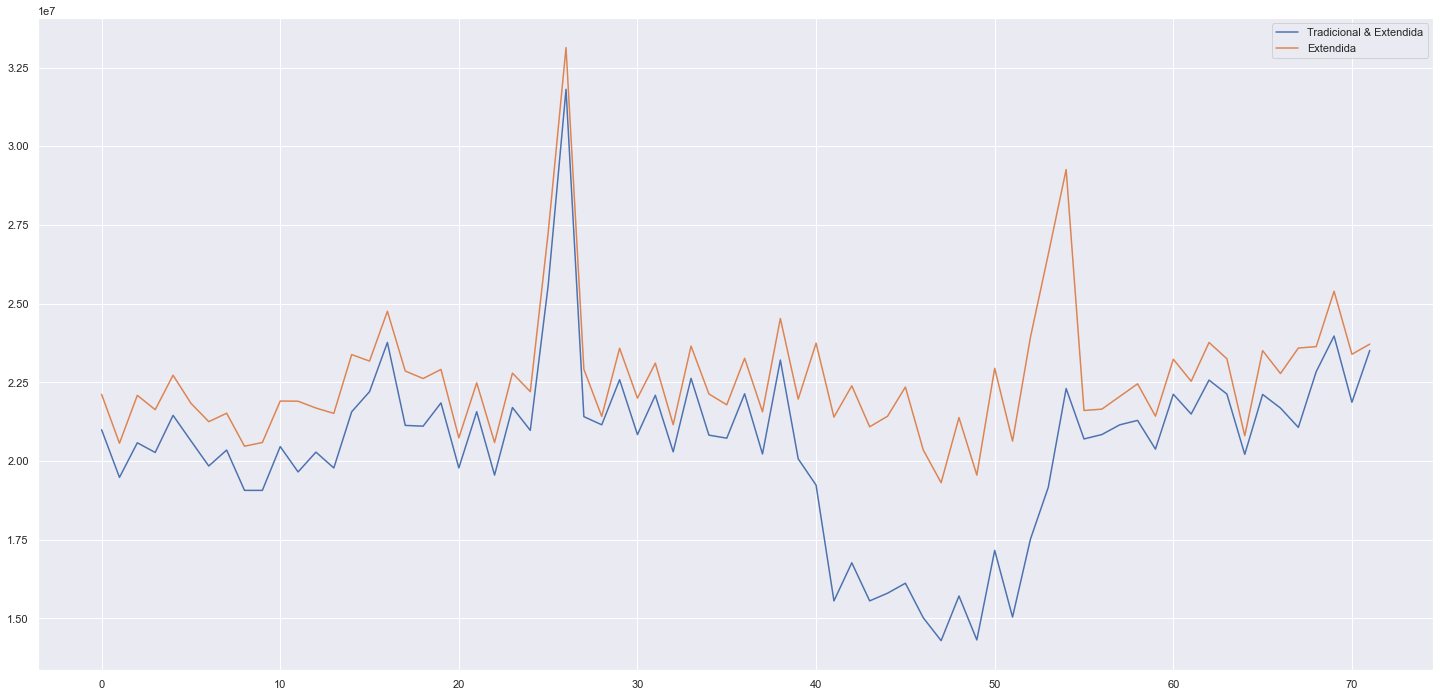

In [78]:
# Vamos plotar essas informações no tempo para avaliar melhor
aux1 = df4[( df4["promo"] == 1 ) & ( df4["promo2"] == 1 )][["year_week", "sales"]].groupby( "year_week" ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4["promo"] == 1 ) & ( df4["promo2"] == 0 )][["year_week", "sales"]].groupby( "year_week" ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

### H7. Stores opened during the Christmas holiday should sell more.

**FALSA** Lojas abertas durante o feriado do Natal vendem menos.

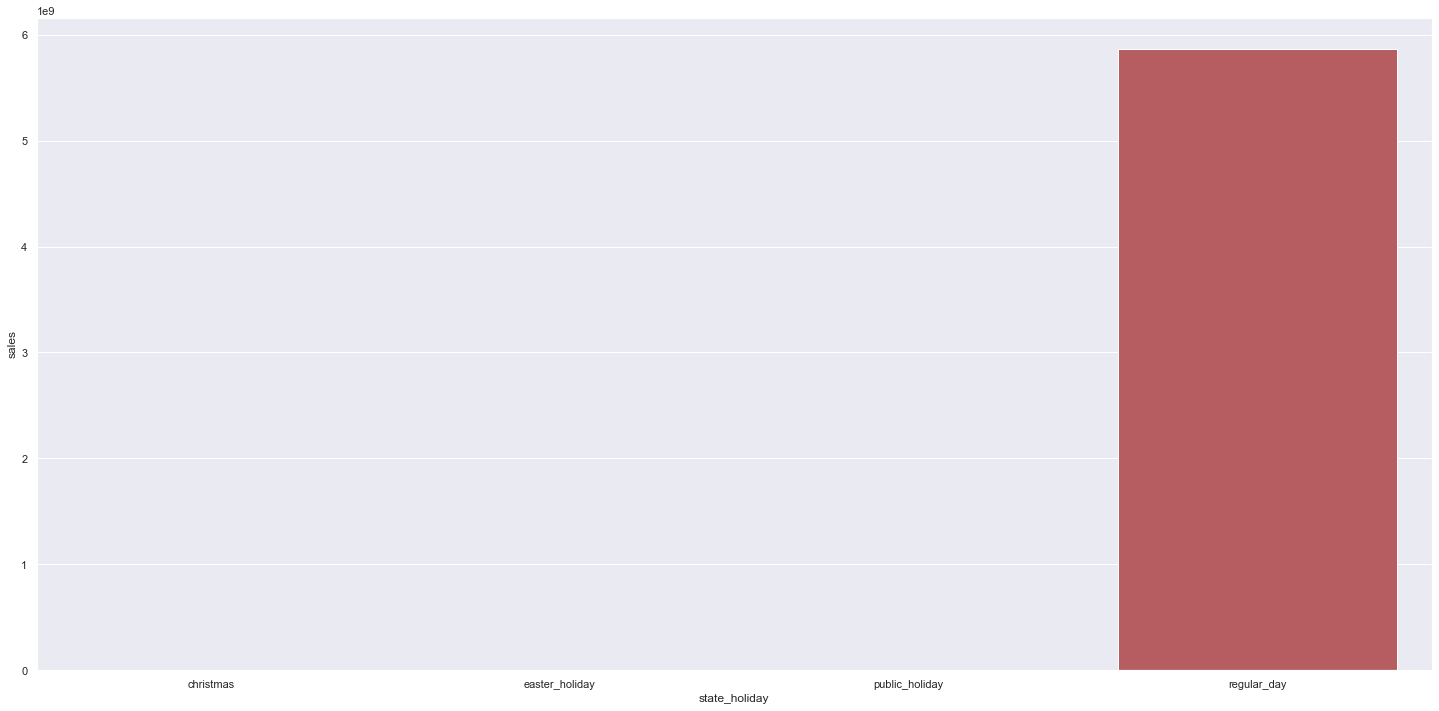

In [79]:
aux1 = df4[["state_holiday", "sales"]].groupby("state_holiday").sum().reset_index()
sns.barplot( x="state_holiday", y="sales", data=aux1);

Para visualizar algo precisamos remover os "regular_day" e trabalhar só com os dias de feriado.

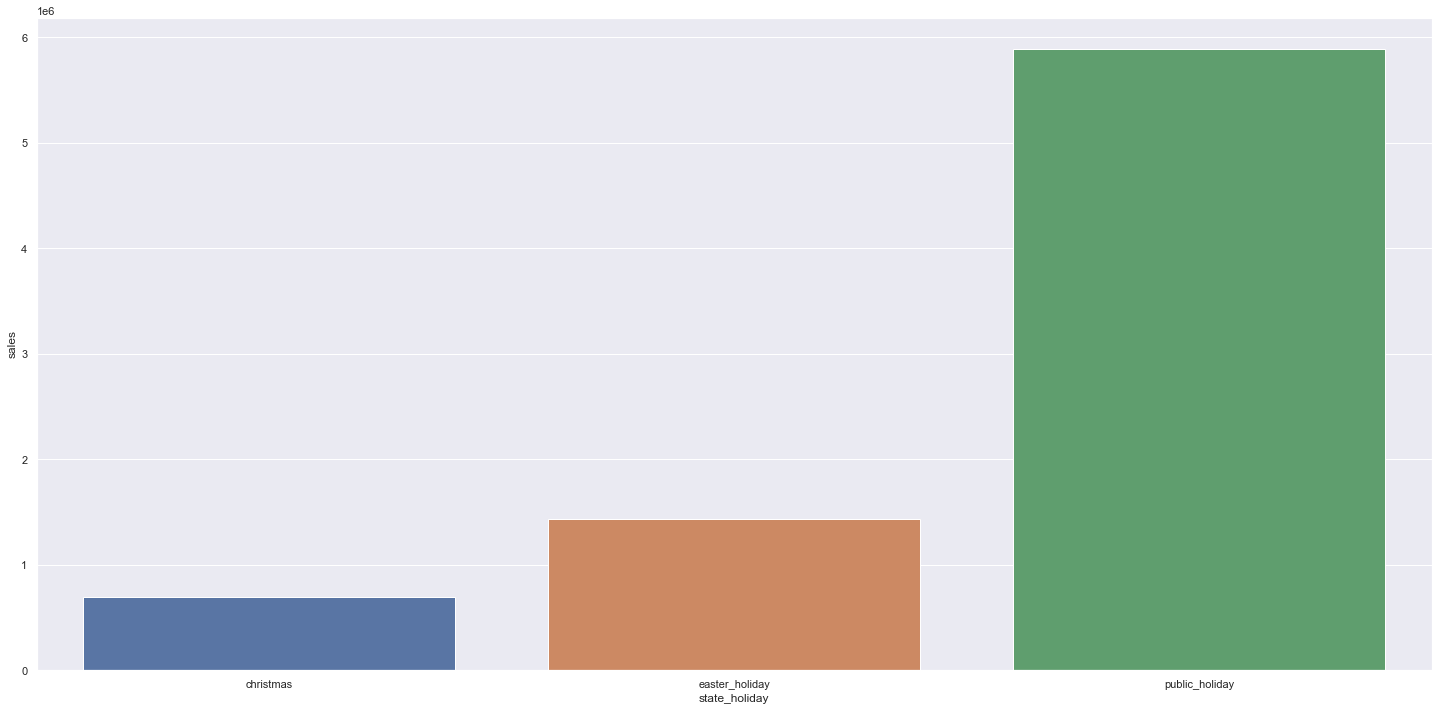

In [80]:
aux = df4[df4["state_holiday"] != "regular_day"]
aux1 = aux[["state_holiday", "sales"]].groupby("state_holiday").sum().reset_index()
sns.barplot( x="state_holiday", y="sales", data=aux1);

Já conseguimos ver que não há mais vendas no feriado de Natal.

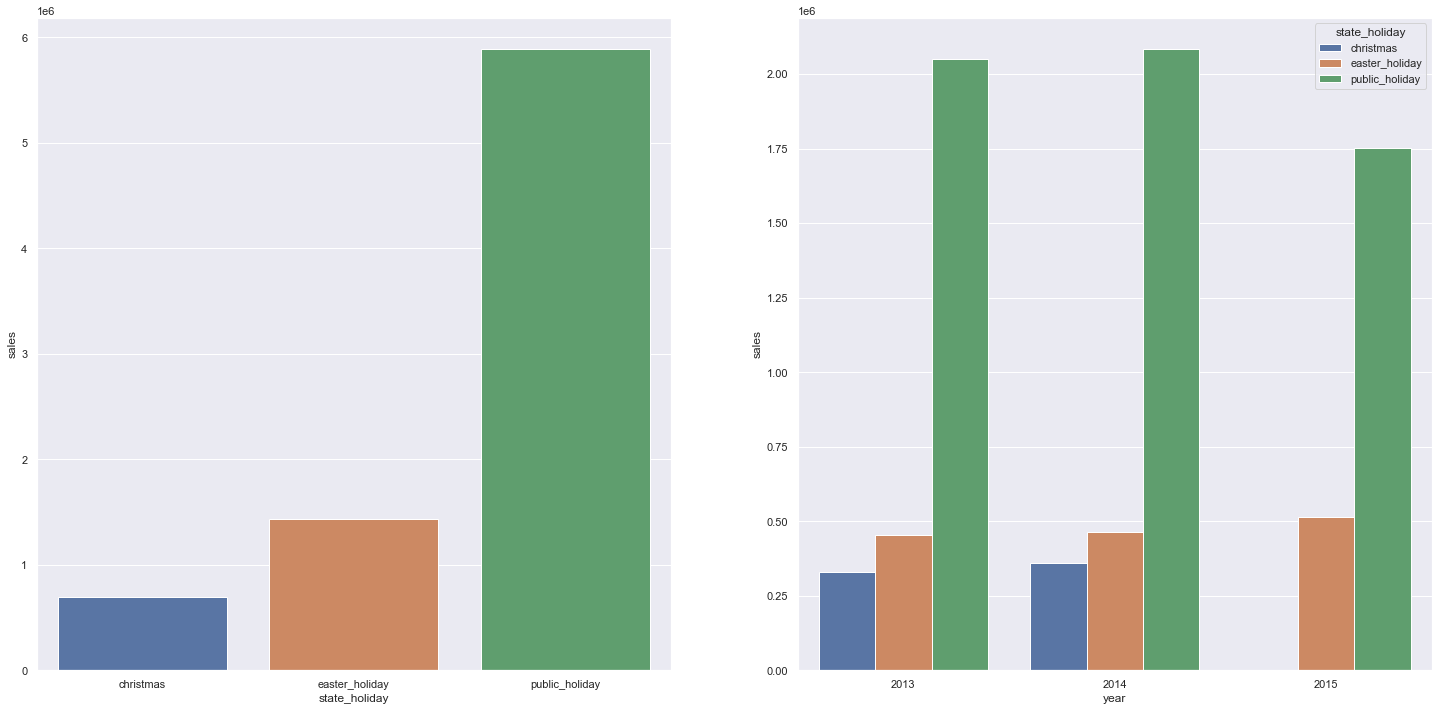

In [81]:
# Verificando se houve alguma mudança no tempo em relação às vendas no Natal

plt.subplot( 1,2,1 )
aux = df4[df4["state_holiday"] != "regular_day"]
aux1 = aux[["state_holiday", "sales"]].groupby( "state_holiday" ).sum().reset_index()
sns.barplot( x="state_holiday", y="sales", data=aux1);

plt.subplot( 1,2,2 )
aux2 = aux[["year", "state_holiday", "sales"]].groupby( ["year", "state_holiday"] ).sum().reset_index()
sns.barplot( x="year", y="sales", hue="state_holiday", data=aux2);
# hue: tipos de barras que quero no meu gráfico

As vendas em azul (Christmas) sempre vendem menos nos períodos relatados nos dados.

### H8. Stores should sell more over the years.

**FALSA** Lojas vendem menos ao longo dos anos

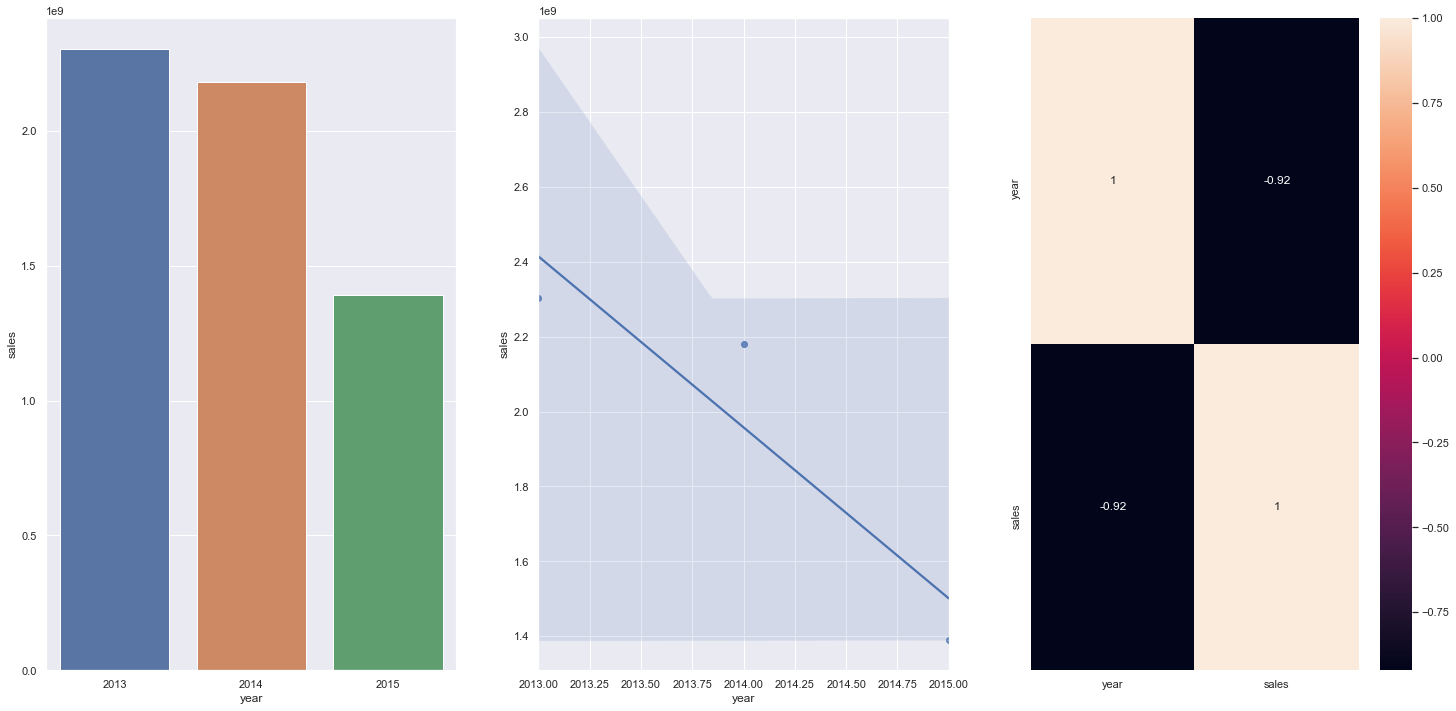

In [82]:
aux1 = df4[["year", "sales"]].groupby( "year" ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x="year", y="sales", data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x="year", y="sales", data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method="pearson" ), annot=True );

Tendência de queda nas vendas ao longo dos anos, com altíssima correlação (-0.92). Conforme os anos vão avançando as vendas vão caindo, mas cuidado que nesse caso o 2015 não está fechado. Idealmente devemos pegar períodos fechados para avaliar. Mas é um indício que o ano é uma variável importante para o modelo.

### H9. Stores should sell more in the second half of the year.

**FALSA** Lojas vendem menos no segundo semestre do ano

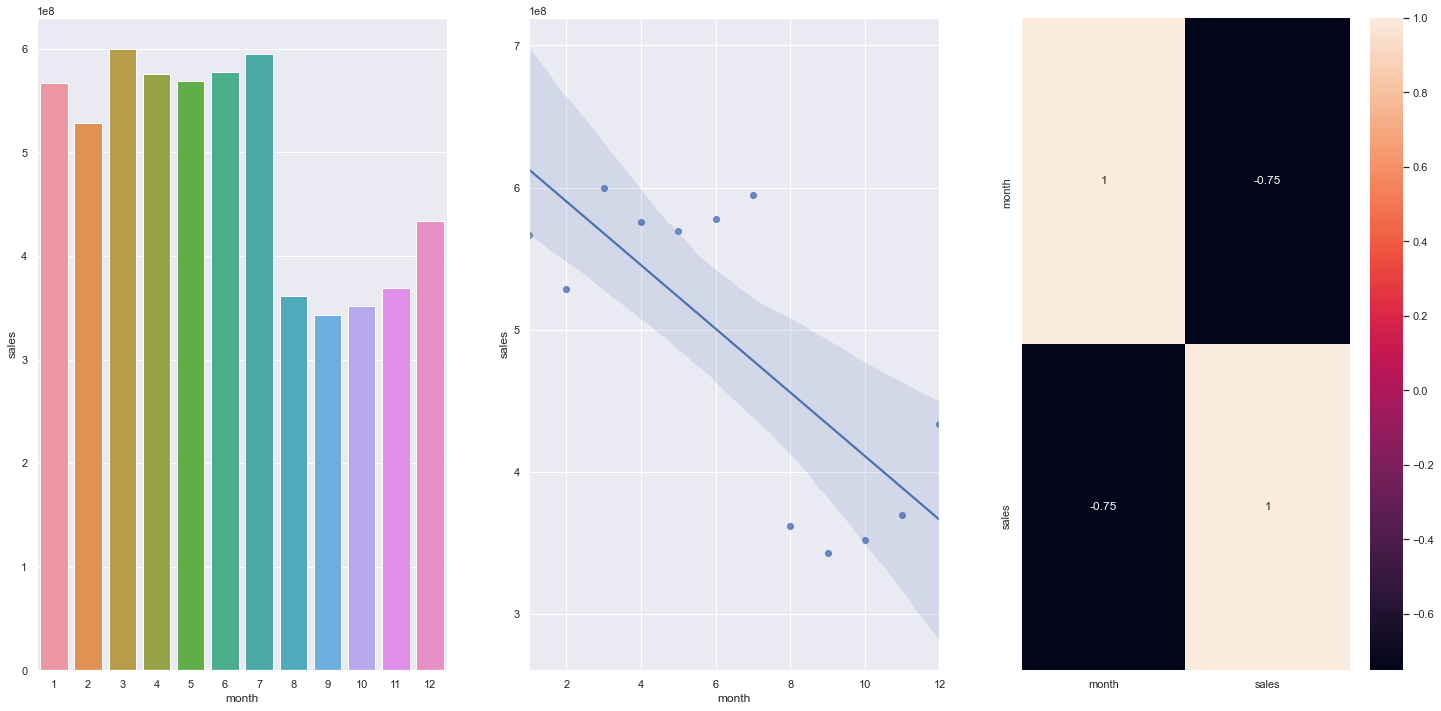

In [83]:
aux1 = df4[["month", "sales"]].groupby( "month" ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x="month", y="sales", data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x="month", y="sales", data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method="pearson" ), annot=True );

No segundo semestre dos anos a Rossman vende menos. 

### H10. Stores should sell more after the 10th of each month.

**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mes.

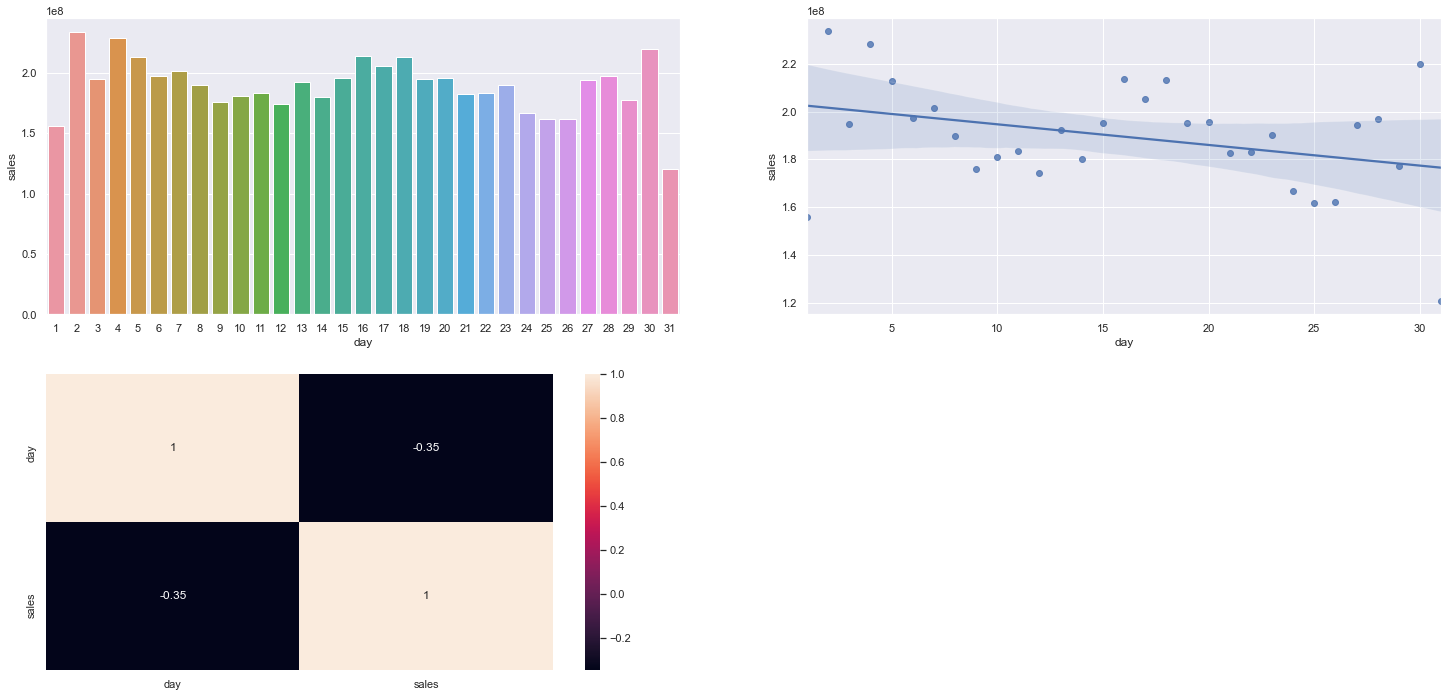

In [84]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

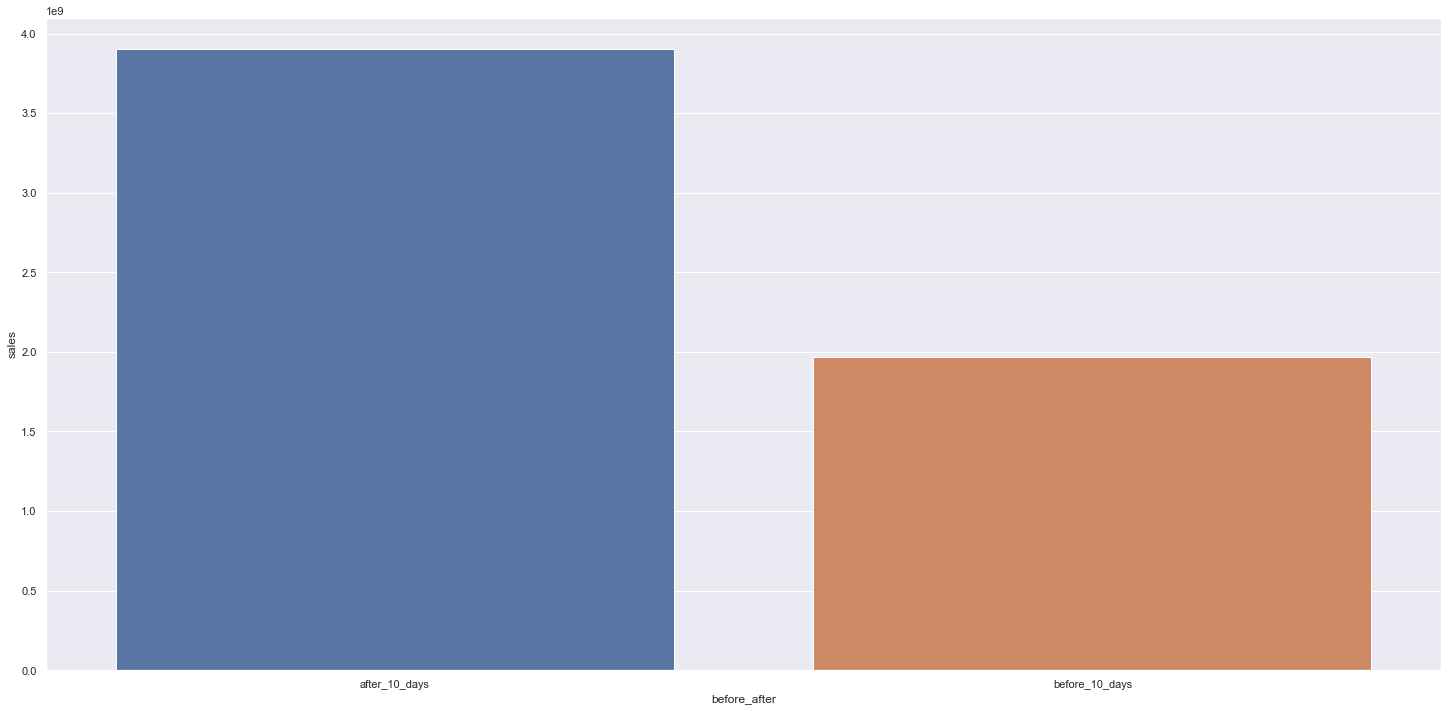

In [85]:
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

sns.barplot( x='before_after', y='sales', data=aux2 );

### H11. Stores should sell less on weekends.

**VERDADEIRA** Lojas vendem menos nos final de semana

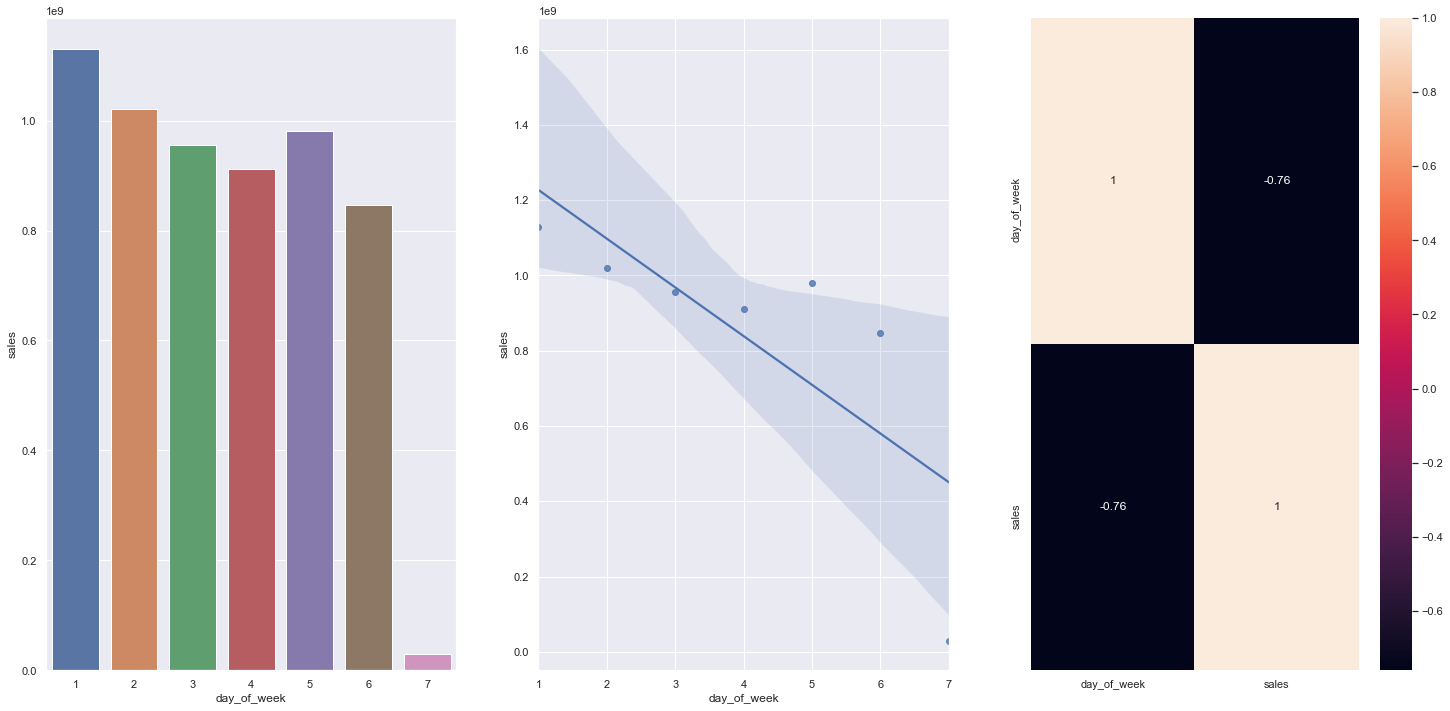

In [86]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H12. Stores should sell less during school holidays.

**VERDADEIRA** Lojas vendem menos durante os feriados escolares, exceto nos meses de Julho e Agosto.

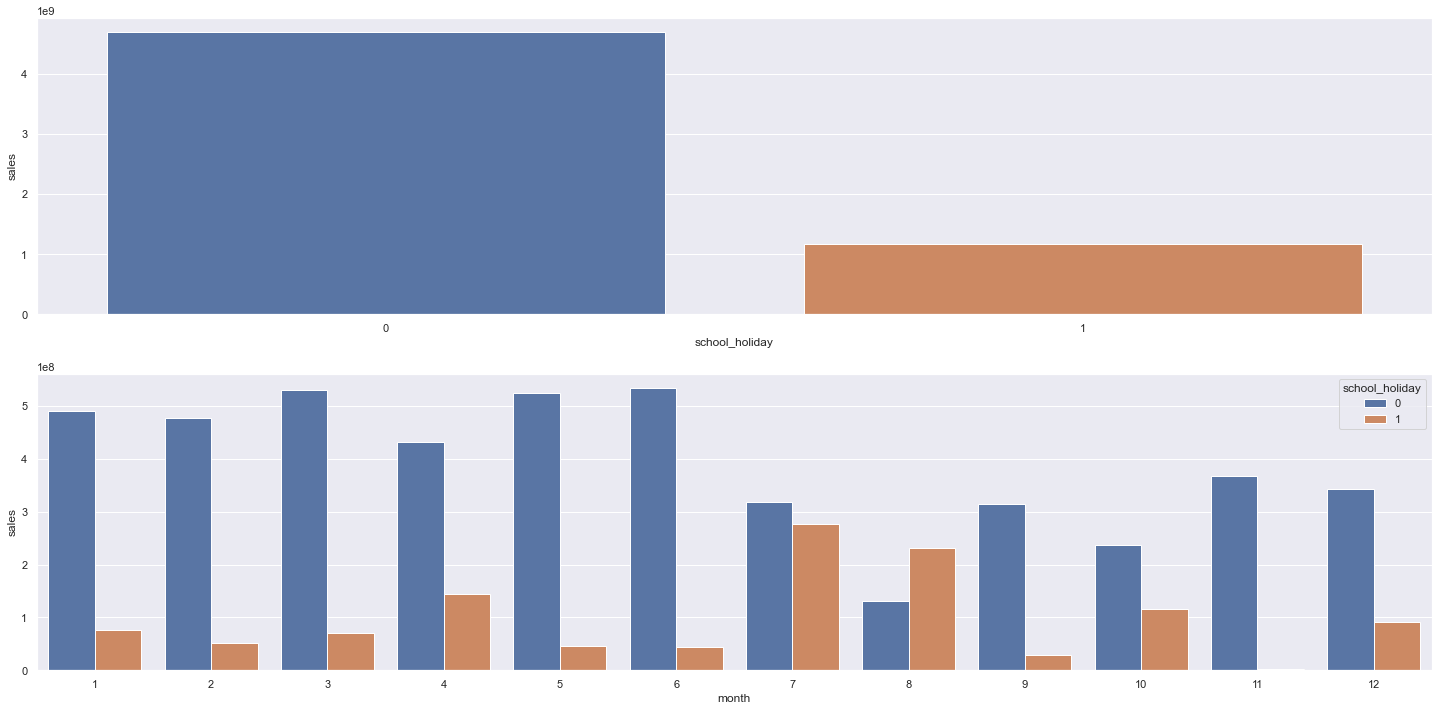

In [87]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

### 4.2.1. Summary of Hypothesis

In [88]:
from tabulate import tabulate

In [89]:
# Criando uma tabela como uma listas de listas para colocar um resumo sobre as hipóteses e facilitar o entendimento futuro dessa parte do projeto.

tab =[['Hipóteses', 'Conclusão', 'Relevância'],
      ['H1', 'Falsa', 'Baixa'],  
      ['H2', 'Falsa', 'Media'],  
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H6', 'Falsa', 'Baixa'],
      ['H7', 'Falsa', 'Media'],
      ['H8', 'Falsa', 'Alta'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Verdadeira', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Baixa'],
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3. Multivariate Analysis

### 4.3.1. Numerical Attributes

In [90]:
num_attributes.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0


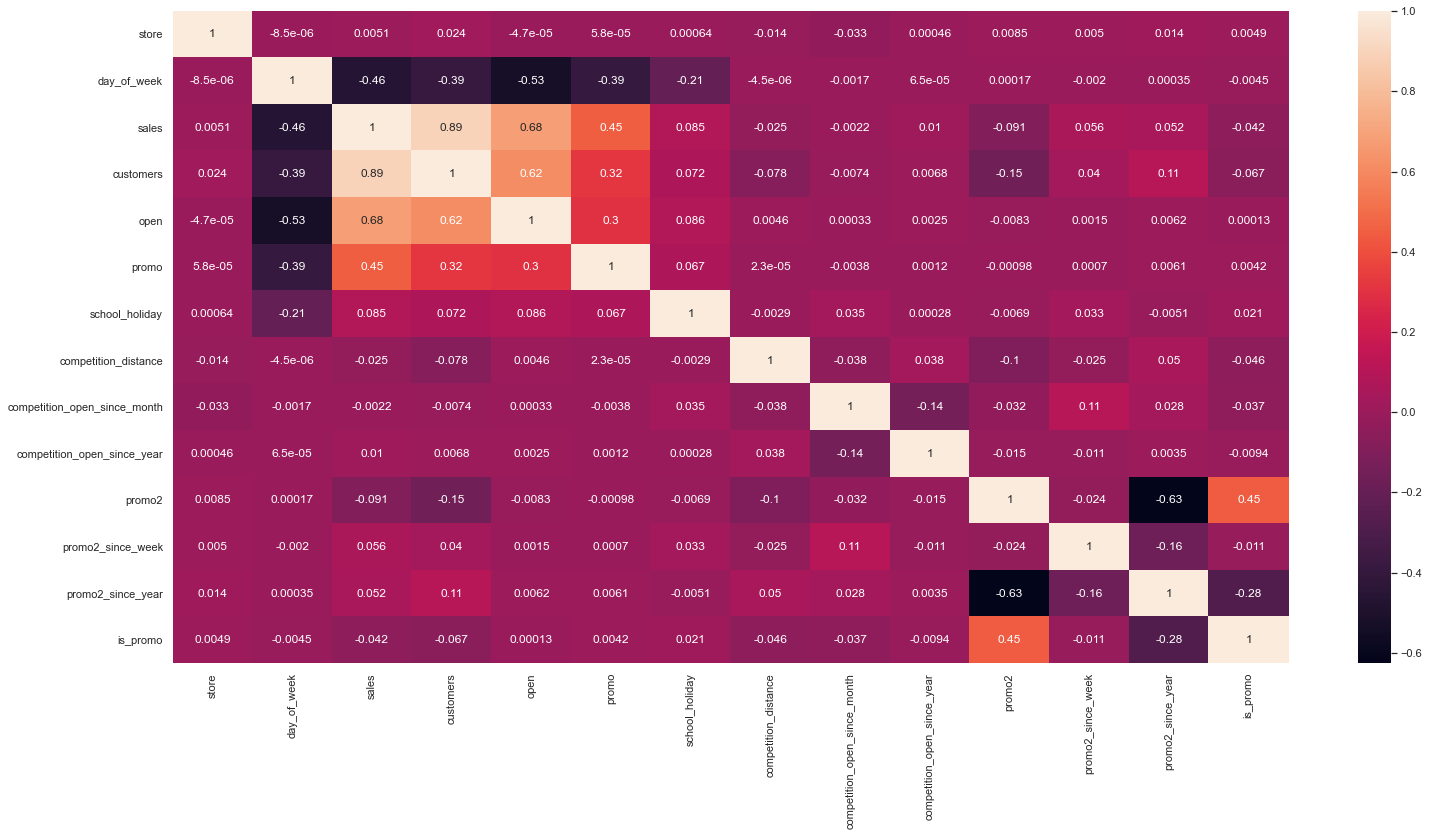

In [91]:
correlation = num_attributes.corr( method="pearson")
sns.heatmap( correlation, annot=True );

### 4.3.2. Categorical Attributes

In [92]:
cat_attributes.head()
# atenção, esse foi um dataset antigo, ainda não organizado 

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [93]:
a = df4.select_dtypes( include='object' )
a.head()
# obs: year_week está como objeto mas é uma data

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [94]:
# Precisamos da biblioteca stats do scipy

In [95]:
cm = pd.crosstab( a["state_holiday"], a["store_type"] ).values
# Fez uma tabela com a combinação entre as variáveis e conta o número de linhas daquela combinação
# Essa é uma matriz de confusão ou tabela de contigência
# o .values era o 'antigo' as_matrix()

In [96]:
cm

array([[     4,     66,      0,      1],
       [    36,    100,      0,      9],
       [   236,    285,     65,    108],
       [456766,  15109, 112903, 258650]], dtype=int64)

In [97]:
a[( a["state_holiday"] == "christmas" ) & ( a["store_type"] == "a" )]
# O resultado deu 4 linhas, que é exatamente o número que ele mostra na matriz acima

,state_holiday,store_type,assortment,year_week
241499,christmas,a,extended,2014-51
241977,christmas,a,extended,2014-51
616339,christmas,a,extended,2013-51
616908,christmas,a,extended,2013-51


In [98]:
chi2 = ss.chi2_contingency( cm )[0]

In [99]:
chi2

12792.159524019908

4 resultados:
1) resultado do teste qi^2 (o teste de qi^2 baseado no Pearson
2) p-valor
3) numero de graus de liberdade que foi feito o teste
4) tabela de frequencia

Por enquanto o primeiro valor que nos interessa para compor a fórmula abaixo

In [100]:
# n is the grand total of observations
n = cm.sum()

In [101]:
# k being the number of columns.
# r being the number of rows.
r,k = cm.shape

In [102]:
# Utilizando a fórmula de V de Cramér
v = np.sqrt ( (chi2/n) / ( min( k-1, r-1 ) ) )

In [103]:
v

0.07106457093267678

V de cramer vai de 0 a 1. (não tem correlação negativa entre as variaveis categóricas) 
Quanto mais próximo de 0, menor a correlação.

In [104]:
# Vamos precisar aplicar essa fórmula muitas vezes então vamos fazer uma função
# função cramer_v vai receber as duas variáveis categoricas que quero avaliar a correlação

def cramer_v(x, y):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r,k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    
    return np.sqrt ( (chi2/n) / ( min( k-1, r-1 ) ) )

In [105]:
cramer_v( a["state_holiday"],a["store_type"] )

0.07106457093267678

Precisamos criar uma tabela similar ao que vimos na parte numérica e criar o heatmap.

Antes disso, vamos fazer uma correação do viés (bias correction): (verificando as formulas)

In [106]:
def cramer_v(x, y):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r,k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt ( (chi2/n) / ( min( k-1, r-1 ) ) )

In [107]:
# Faz todas as combinações possíveis

a1 = cramer_v( a["state_holiday"],a["state_holiday"] )
a2 = cramer_v( a["state_holiday"],a["store_type"] )
a3 = cramer_v( a["state_holiday"],a["assortment"] )

a4 = cramer_v( a["store_type"],a["state_holiday"] )
a5 = cramer_v( a["store_type"],a["store_type"] )
a6 = cramer_v( a["store_type"],a["assortment"] )

a7 = cramer_v( a["assortment"],a["state_holiday"] )
a8 = cramer_v( a["assortment"],a["store_type"] )
a9 = cramer_v( a["assortment"],a["assortment"] )

# Dataframe do Pandas para montar a tabela:

pd.DataFrame( {"state_holiday": [a1, a2, a3],
            "store_type": [a4, a5, a6],
            "assortment": [a7, a8, a9] })

,state_holiday,store_type,assortment
0,1.000000,0.071065,0.067546
1,0.071065,1.000000,0.538456
2,0.067546,0.538456,1.000000


Queremos deixar os nomes nas linhas e nas colunas:

In [108]:
d = pd.DataFrame( {"state_holiday": [a1, a2, a3],
            "store_type": [a4, a5, a6],
            "assortment": [a7, a8, a9] })

d = d.set_index( d.columns )

In [109]:
d

,state_holiday,store_type,assortment
state_holiday,1.000000,0.071065,0.067546
store_type,0.071065,1.000000,0.538456
assortment,0.067546,0.538456,1.000000


<AxesSubplot:>

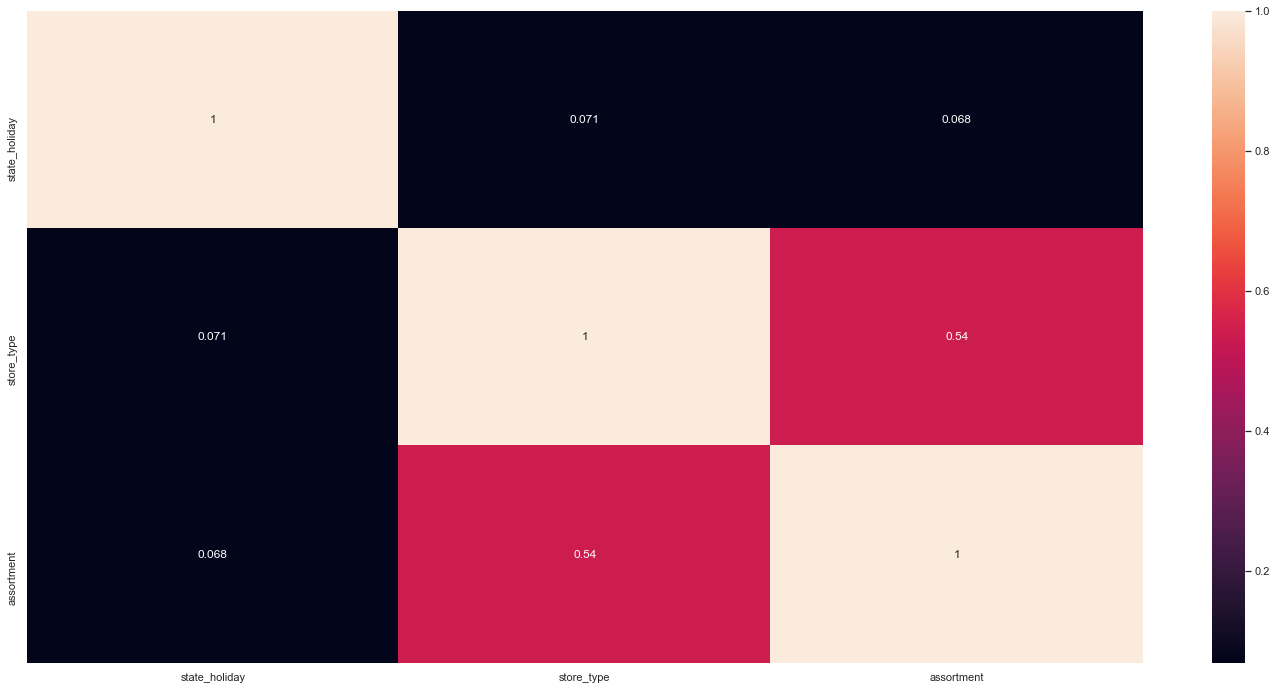

In [110]:
sns.heatmap( d, annot=True)

# 5.0. STEP 05 - DATA PREPARATION

In [111]:
df5 = df4.copy()

In [112]:
df5.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
is_promo                                 int64
year                                     int64
month                                    int64
day                                      int64
week_of_year                            UInt32
year_week                               object
competition_s

## 5.1. Normalization

Primeiramente, avaliamos quais variáveis devem ser normalizadas. Para fazer isso devemos olhar a distribuição das variáveis, que está na análise univariada (tópico 4.1.2 Numerical Variables). Nenhuma variável possui uma distribuição normal, portanto não faremos a normalização.

## 5.2. Rescaling

In [113]:
a = df5.select_dtypes( include=[ "int64", "int32", "float32","float64"] )

In [114]:
a.sample(5)

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,competition_time_month,promo_time_week
267119,980,6,7240,0,0,4420.0,9,2005,0,48,2014,0,2014,11,29,112,0
169310,946,1,6089,1,0,2220.0,12,2011,1,14,2015,0,2015,3,2,39,-4
921247,1043,4,15036,1,1,420.0,3,2006,0,13,2013,0,2013,3,28,86,0
654826,1107,5,6675,1,0,1400.0,6,2012,1,13,2010,0,2013,11,22,17,191
499945,96,3,4189,0,0,8780.0,2,2005,1,37,2009,1,2014,4,9,111,239


<AxesSubplot:xlabel='competition_distance'>

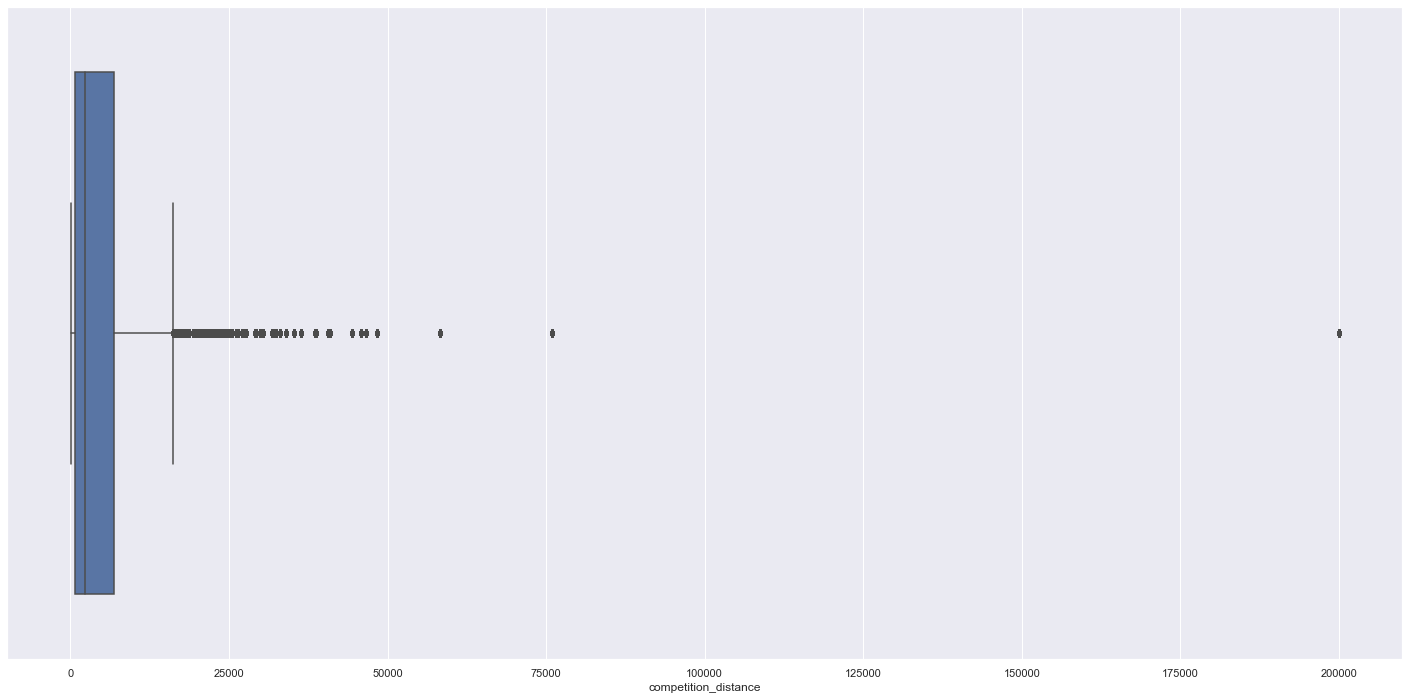

In [115]:
# day_of_week
# competition_distance
# year
# month
# day
# week_of_year
# competition_time_month
# promo_time_week

# Dentre essas variaveis acima, as de natureza cíclica vamos trabalhar na próxima etapa: day_of_week, month, day, week_of_year

# Vamos fazer a re-escala das variaveis: competition_distance, year, competition_time_month e promo_time_week e basta decidir entre as duas tecnicas
# Min Max Scalers ou Robust Scaler. Para isso, vamos verificar se elas tem outliers ou não...

sns.boxplot( df5["competition_distance"])

A variável "competition_distance" possui muitos outliers, o que já era esperado. Na etapa de Fill NA, utilizamos vamos muito altos para substituir valores NA (inserimos outliers). Portanto, usarmos o RobustScaler para esta variável.

In [116]:
# Adicionando pacote: from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

In [120]:
# Instanciando a classe do RobustScaler e guardando em uma variável chamada rs
rs = RobustScaler()

# Aqui usaremos: competition_distance, year, competition_time_month e promo_time_week
# Usando método fit_transform: encontra os parametros da formula (quartil 1 e quartil 3) na coluna e ja aplica a formula nos dados 

# competition_distance
# dois colchetes e o .values para pegar os valores das colunas e vamos substituir a coluna original
df5["competition_distance"] = rs.fit_transform( df5[["competition_distance"]].values)

# promo_time_week

# year

<AxesSubplot:xlabel='competition_time_month'>

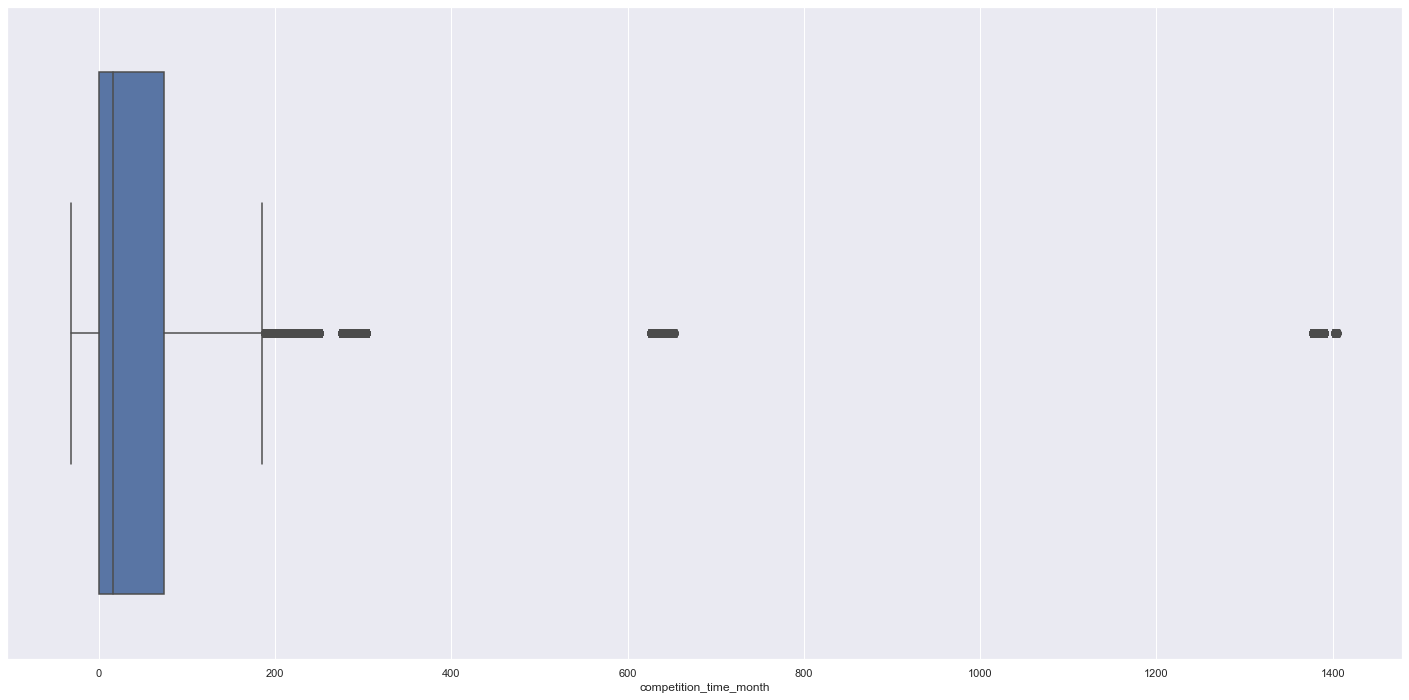

In [121]:
sns.boxplot( df5["competition_time_month"] )

A variável "competition_time_month" também tem bastante outlier. Então vamos usar novamente o RobustScaler.

In [122]:
# competition_time_month
df5["competition_time_month"] = rs.fit_transform( df5[["competition_time_month"]].values)

<AxesSubplot:xlabel='promo_time_week'>

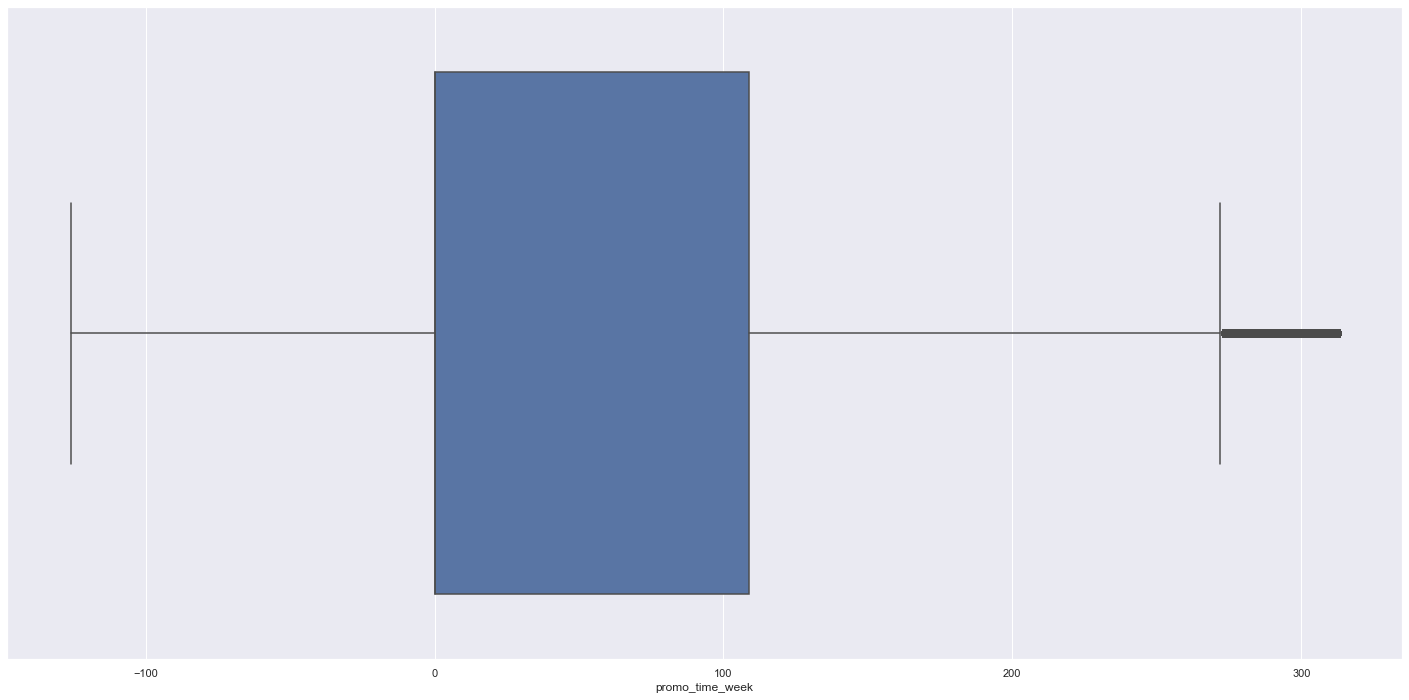

In [123]:
sns.boxplot( df5["promo_time_week"] )

No caso do "promo_time_week" os outliers não parecem ser muito relevante, então podemos arriscar usando o Min Max Scaler (que também é uma classe no sklearn.preprocessing).

In [126]:
mms = MinMaxScaler()

df5["promo_time_week"] = mms.fit_transform( df5[["promo_time_week"]].values)
df5["year"] = mms.fit_transform( df5[["year"]].values)

<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

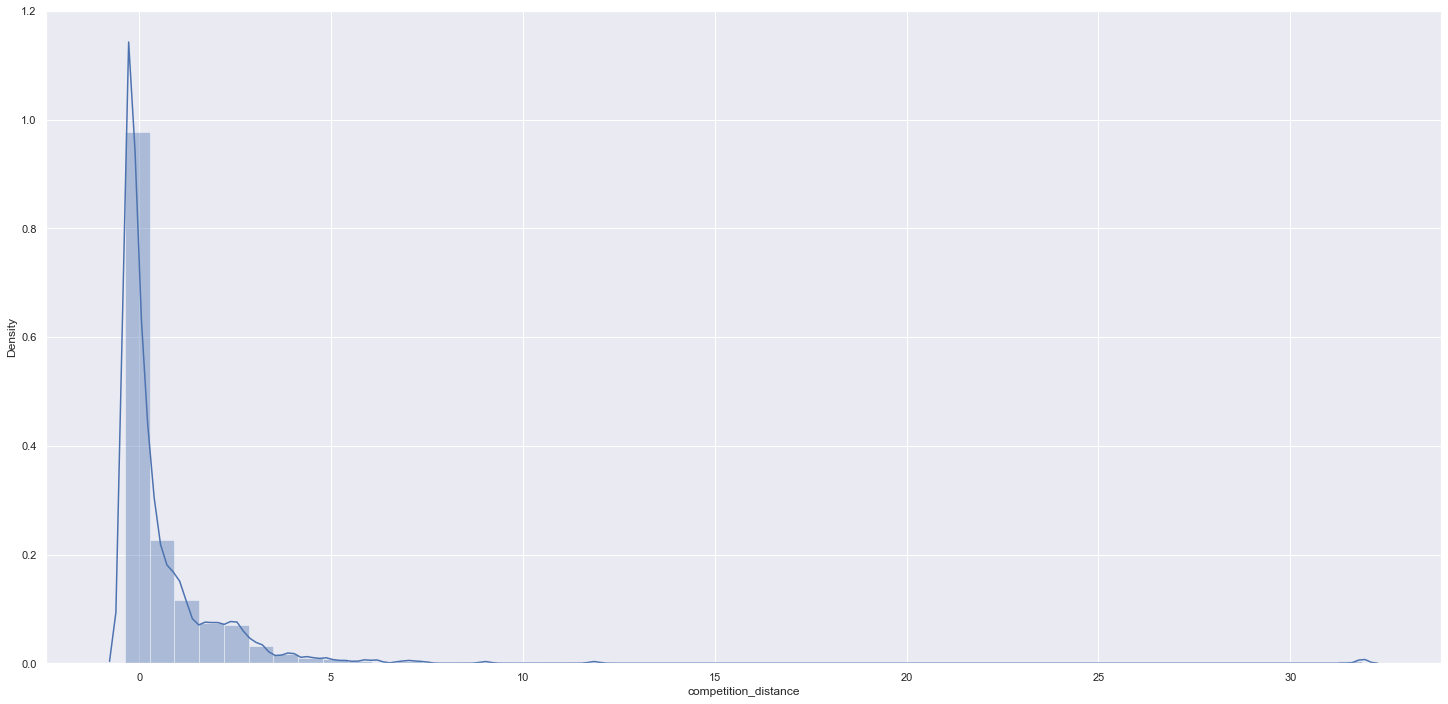

In [128]:
# Plot para visualizarmos a mudança de range das variáveis

sns.distplot( df5["competition_distance"])

Agora temos os mesmos dados de "competition_distance" no mesmo shape que antes mas em um novo range.

## 5.3. Transformation